In [1]:
!pip install catboost
!pip install scikit-optimize
!pip install shap
#!pip install probatus
!pip install lightgbm
!pip install optuna
!pip install dython
#!pip install missingpy

     |████████████████████████████████| 76.3 MB 1.1 MB/s 
     |████████████████████████████████| 100 kB 5.3 MB/s 
     |████████████████████████████████| 371 kB 8.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509240 sha256=2f47a753d37901ff9fb6946a8e58581ee4d0c05de4ac1c6658b4282cb16e356f
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap
     |████████████████████████████████| 308 kB 7.8 MB/s 
     |████████████████████████████████| 209 kB 54.8 MB/s 
     |████████████████████████████████| 80 kB 10.8 MB/s 
     |████████████████████████████████| 75 kB 5.0 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
     |████████████████████████████████| 149 kB 60.7 MB/s 
  Created wh

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from dython.nominal import associations
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from lightgbm import LGBMRanker
import lightgbm as lgb
import optuna
import xgboost as xgb
import shap
#from probatus.feature_elimination import ShapRFECV
shap.initjs()
import pprint
import joblib
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale = 1.2)
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Number of cores
import multiprocessing
cores = multiprocessing.cpu_count() 
cores

2

In [4]:
# Colab Connection
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/1_dl_school/4_kaggle_compete/

Mounted at /content/drive
/content/drive/MyDrive/1_dl_school/4_kaggle_compete


# <center> 1. Light Data Exploration

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
# Numerical cols
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Categorical cols
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
print('train shape', train.shape)
print('test shape', test.shape)

train shape (5282, 20)
test shape (1761, 19)


In [8]:
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [9]:
# train set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
# test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [11]:
# Changing value type
train['Sex'] = train['Sex'].astype('str')
test['Sex'] = test['Sex'].astype('str')
train['IsSeniorCitizen'] = train['IsSeniorCitizen'].astype('str')
test['IsSeniorCitizen'] = test['IsSeniorCitizen'].astype('str')

In [12]:
# Total spent is numerical col but dtype = 'object' => missing values with '' form
for i in feature_cols:
    if train[i].value_counts().sort_index().index[0] == " ":
        print(f'feature = {i}')
        print(f'index_0_train = {train[i].value_counts().sort_index().index[0]}')
        print(f'index_0_test = {test[i].value_counts().sort_index().index[0]}','\n')

feature = TotalSpent
index_0_train =  
index_0_test =   



In [13]:
def fillnan(x):
    '''Filling text NA with None value'''
    if x == ' ':
        return None
    else:
        return float(x)


train['TotalSpent'] = train['TotalSpent'].apply(fillnan)
test['TotalSpent'] = test['TotalSpent'].apply(fillnan)

# <center> 2. Exploratory Data Analysis


## 2.1 Duplicates in Data 

In [14]:
# After dropping duplicates
print('train shape', train.shape)
print('train shape without duplicates', train.drop_duplicates().shape)

train shape (5282, 20)
train shape without duplicates (5268, 20)


As we can see the train set has duplicates that we need to discard


In [15]:
train = train.drop_duplicates()

But also there may be duplicates without a target column

In [16]:
print('train shape without duplicates', train.shape)
print('train shape without duplicates (drop target col)', train.drop('Churn', axis=1).drop_duplicates().shape)

train shape without duplicates (5268, 20)
train shape without duplicates (drop target col) (5260, 19)


For some identical clients the target col has different values. Find them and drop 

In [17]:
indexes_without_noise_clients = set(train.drop('Churn', axis=1).drop_duplicates(keep=False).index)
train = train.loc[indexes_without_noise_clients,:]

## 2.1 Missing Values

In [18]:
# How many NA are in the data?
train_na_count = train.isna().sum().to_frame().rename(columns={0:'train'}).T
test_na_count = test.isna().sum().to_frame().rename(columns={0:'test'}).T
data_na_count = pd.concat([train_na_count,test_na_count])
data_na_count

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
train,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
test,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


**TotalSpent** has 9 NA in train set and 2 NA in test set

In [19]:
train[train['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [20]:
test[test['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


For clients who have NA, ClientPeriod == 0 and all of them aren't in Churn. Change their MonthlySpending and TotalSpent to 0.

In [21]:
train_na_indexes = train[train['TotalSpent'].isna()].index
test_na_indexes = test[test['TotalSpent'].isna()].index
train.loc[train_na_indexes,'TotalSpent'] = 0
train.loc[train_na_indexes,'MonthlySpending'] = 0
test.loc[test_na_indexes,'TotalSpent'] = 0
test.loc[test_na_indexes,'MonthlySpending'] = 0

## 2.2 Numerical Features

In [22]:
print('\t\t\t','TRAIN train','\n\n', train[num_cols].describe(),'\n\n')
print('\t\t\t','TEST train','\n\n', test[num_cols].describe())

			 TRAIN train 

        ClientPeriod  MonthlySpending   TotalSpent
count   5252.000000      5252.000000  5252.000000
mean      32.576352        65.025267  2300.361300
std       24.505058        30.226374  2269.097806
min        0.000000         0.000000     0.000000
25%        9.000000        35.737500   407.950000
50%       29.000000        70.500000  1417.325000
75%       55.000000        90.100000  3826.362500
max       72.000000       118.750000  8684.800000 


			 TEST train 

        ClientPeriod  MonthlySpending   TotalSpent
count   1761.000000      1761.000000  1761.000000
mean      32.293583        64.249830  2256.483135
std       24.593736        29.873909  2260.501794
min        0.000000         0.000000     0.000000
25%        9.000000        35.650000   405.600000
50%       29.000000        70.050000  1356.300000
75%       56.000000        89.400000  3759.050000
max       72.000000       117.350000  8496.700000


Train & Test distributions doesn't differ sighnificantly for numerical features

In [23]:
train_2 = train.drop('Churn', axis=1).copy()
train_2['train_type'] = 'train'
test_2 = test.copy()
test_2['train_type'] = 'test'
data = pd.concat([train_2,test_2], ignore_index=True)

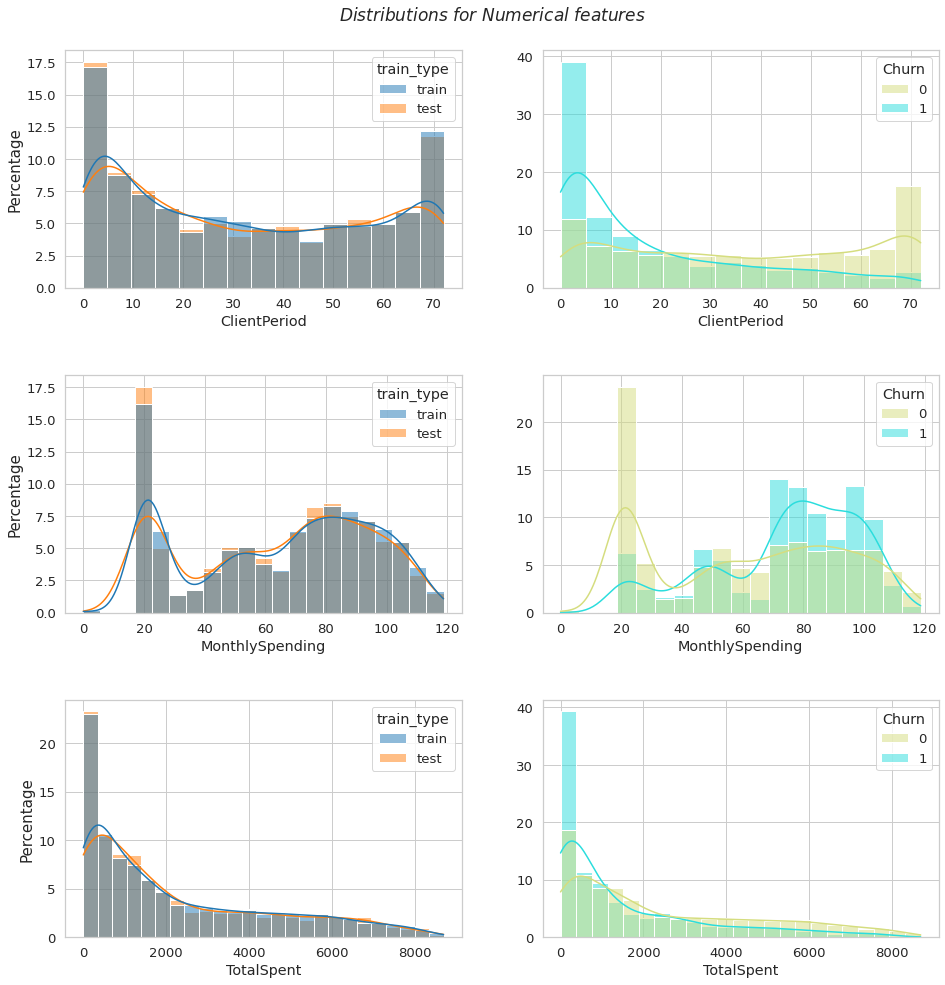

In [24]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(13, 13))
fig.tight_layout(w_pad=4, h_pad=6)
fig.suptitle(r'$Distributions\ for\ Numerical\ features$', y=1.03, fontsize=17)
for i, feature in enumerate(num_cols):
    sns.histplot(data=data, x=feature, kde=True, hue='train_type', palette='tab10', ax=axes[i,0], stat='percent', common_norm=False)
    sns.histplot(data=train, x=feature, kde=True, hue='Churn', palette='rainbow_r', ax=axes[i,1], stat='percent', common_norm=False)
    axes[i,0].set_ylabel('Percentage', fontsize=15)
    axes[i,1].set_ylabel('')

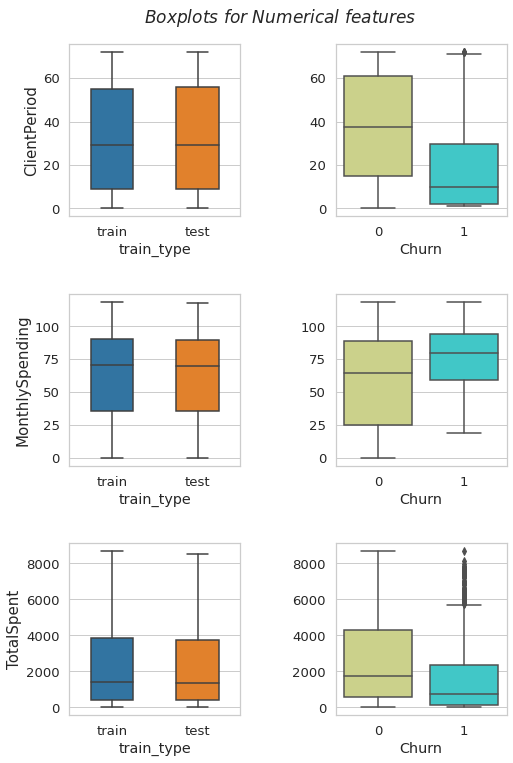

In [25]:
fig, axes = plt.subplots(len(num_cols),2, figsize = (7,10))
fig.tight_layout(w_pad = 5, h_pad = 5)
fig.suptitle(r'$Boxplots\ for\ Numerical\ features$', y=1.03, fontsize=17)
for i, feature in enumerate(num_cols):
    sns.boxplot(data=data, y=feature, x='train_type', palette='tab10', ax=axes[i,0], width=0.5)
    sns.boxplot(data=train, y=feature, x='Churn', palette='rainbow_r', ax=axes[i,1])
    axes[i,0].set_ylabel(f'{feature}', fontsize=15)
    axes[i,1].set_ylabel('')    

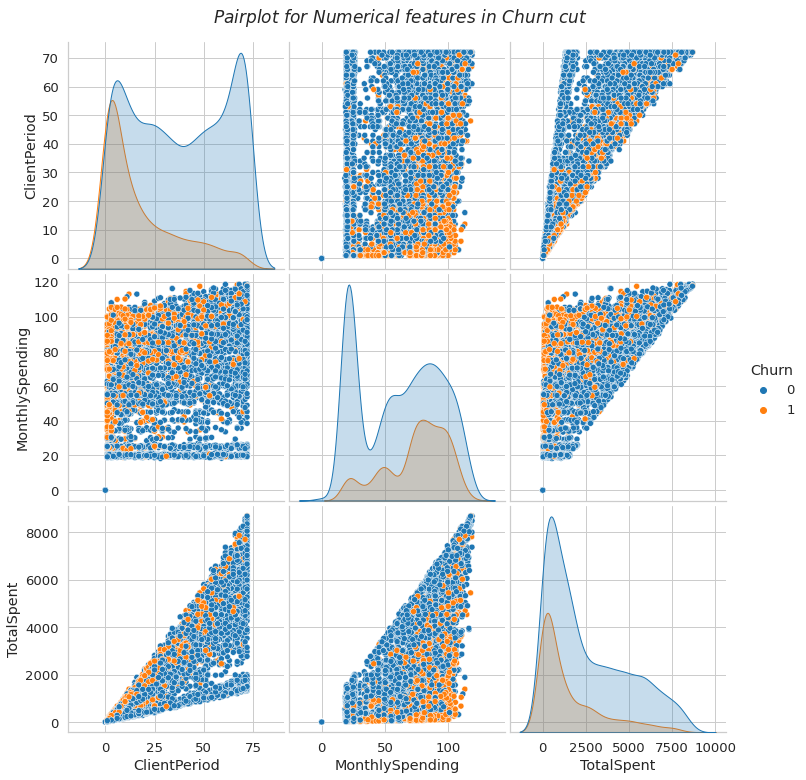

In [26]:
ax_1 = sns.pairplot(train[num_cols + ['Churn']], hue = 'Churn', palette ='tab10', height = 3.5 )
ax_1.fig.suptitle(r'$Pairplot\ for\ Numerical\ features\ in\ Churn\ cut$', y=1.03, fontsize=17)
plt.show()

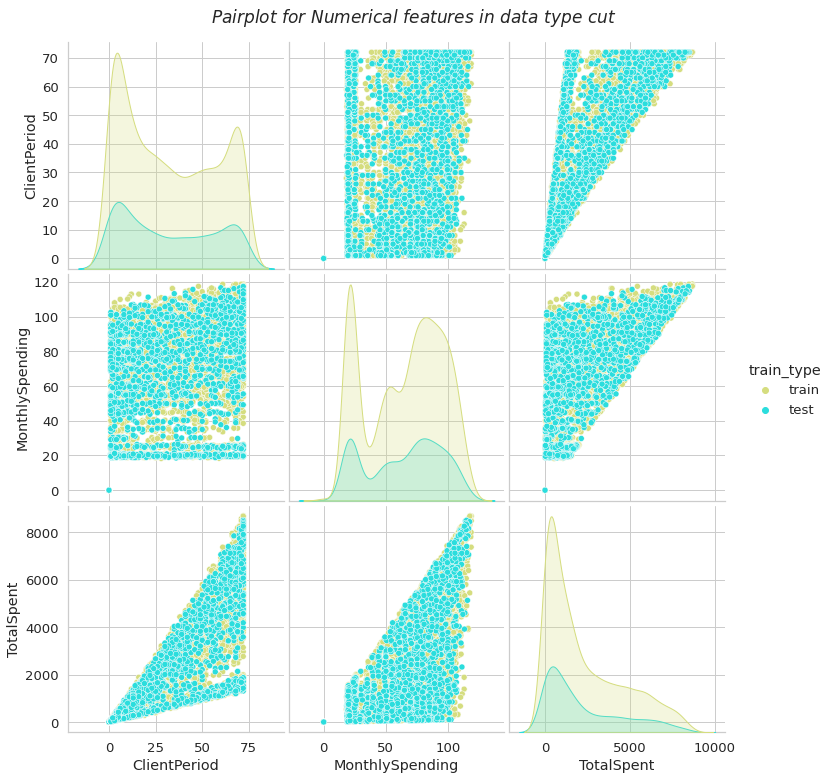

In [27]:
ax_2 = sns.pairplot(data[num_cols + ['train_type']], hue = 'train_type', palette ='rainbow_r', height = 3.5)
ax_2.fig.suptitle(r'$Pairplot\ for\ Numerical\ features\ in\ data\ type\ cut$', y=1.03, fontsize=17)
plt.show()

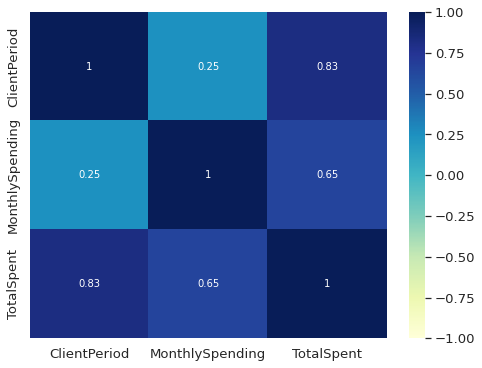

In [28]:
# Correlation btw numerical features
train_num_corr = data[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(train_num_corr, annot=True, vmin=-1, vmax=1, center=0, cmap='YlGnBu')
plt.show()

**Some conlusions:**
* There is a difference in distributions in the "Churn" cut
* There are no sighnificant outliers
* Total Spent has a heavy right tail

## 2.3 Categorical Features

In [29]:
# N unique values for cat features
cat_nunique_train = train[cat_cols].nunique().to_frame().rename(columns = {0 : 'N_Unique_train'}).T
cat_nunique_test = train[cat_cols].nunique().to_frame().rename(columns = {0 : 'N_Unique_test'}).T
cat_nunique = pd.concat([cat_nunique_train,cat_nunique_test])
cat_nunique.T

,N_Unique_train,N_Unique_test
Sex,2,2
IsSeniorCitizen,2,2
HasPartner,2,2
HasChild,2,2
HasPhoneService,2,2
HasMultiplePhoneNumbers,3,3
HasInternetService,3,3
HasOnlineSecurityService,3,3
HasOnlineBackup,3,3
HasDeviceProtection,3,3


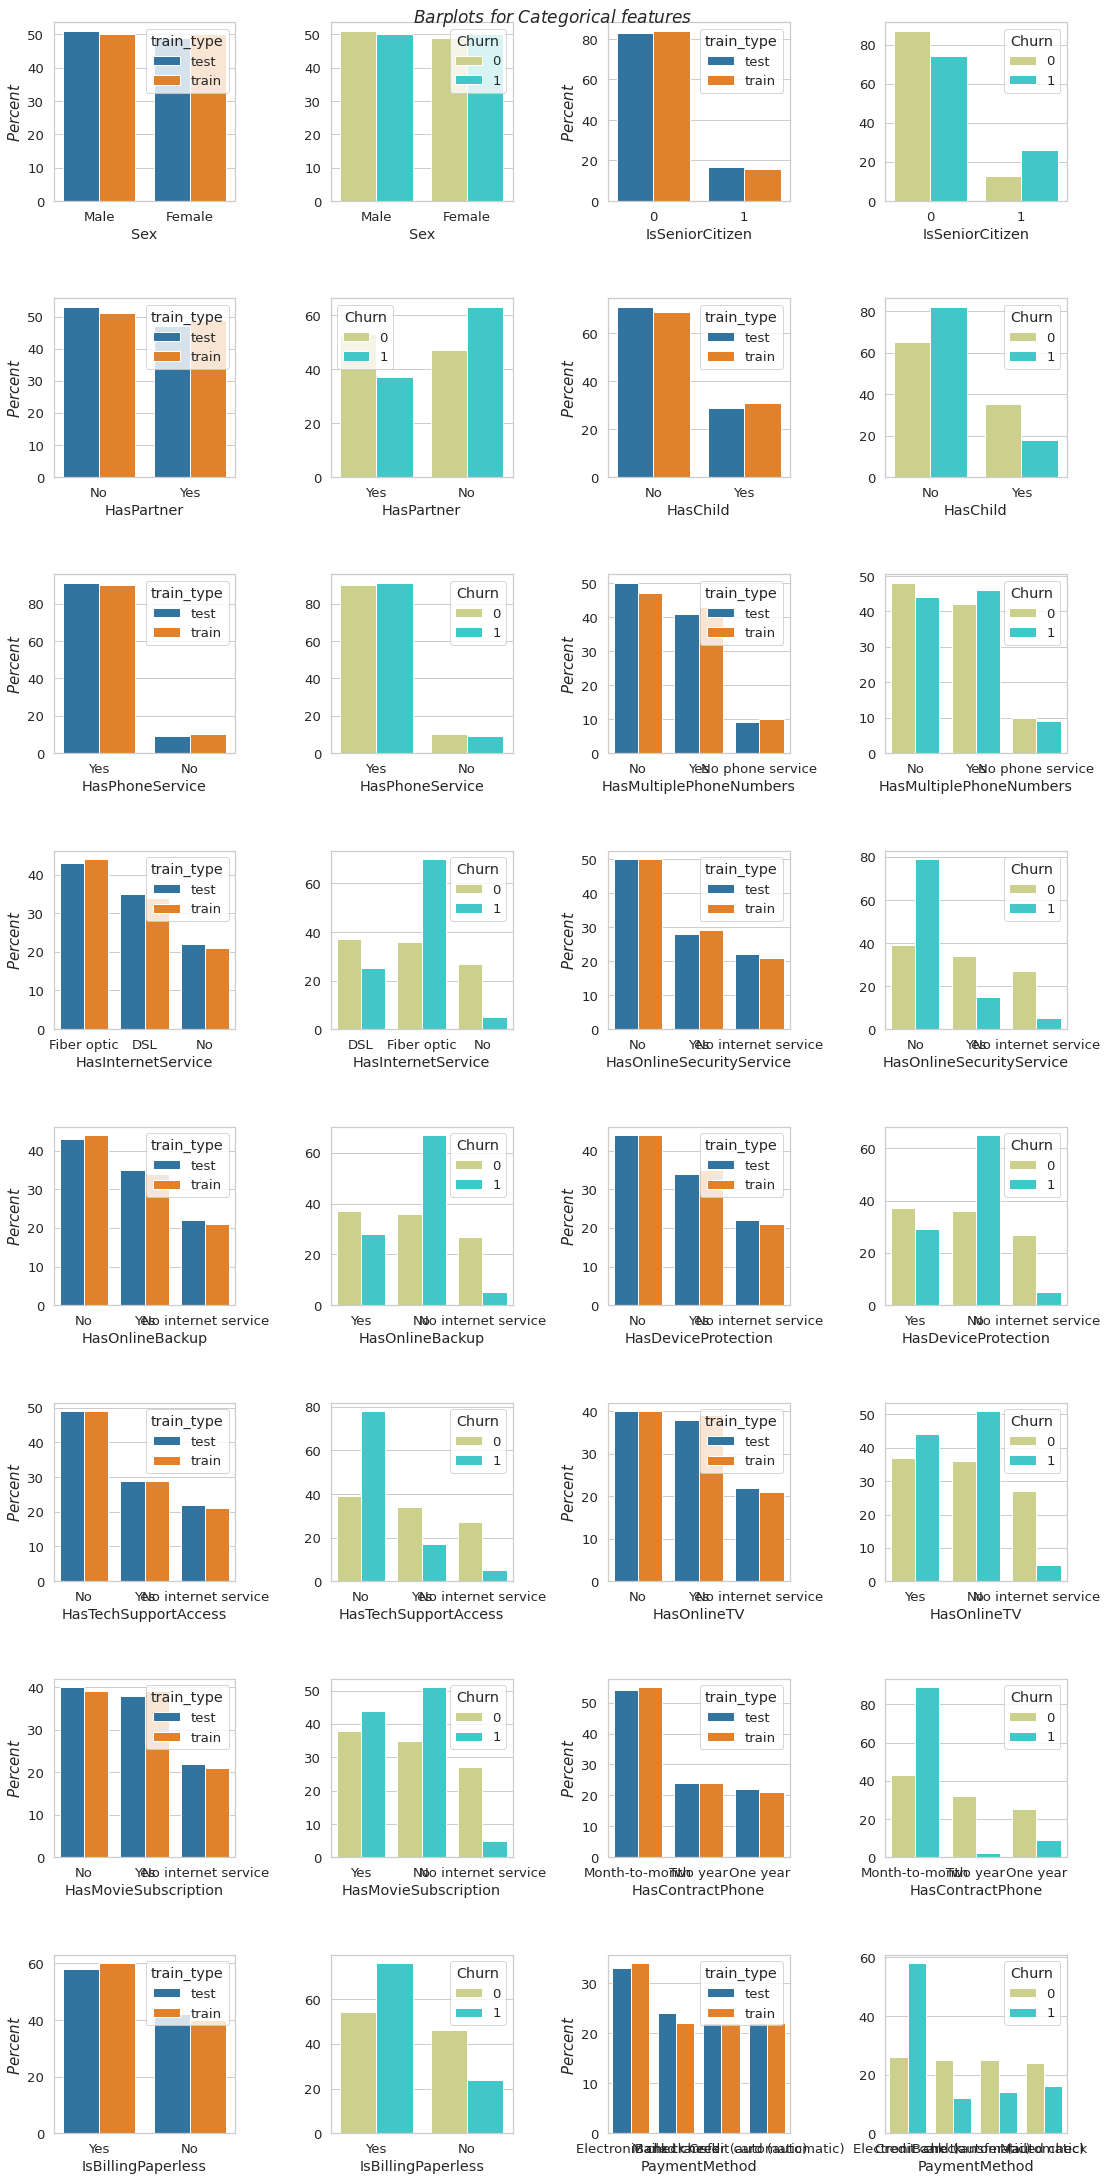

In [30]:
#barplots in percentage for categorical features
fig, axes = plt.subplots(len(cat_cols)//2,4, figsize = (15,30)) # 17 35
fig.tight_layout(w_pad = 5, h_pad = 7)
fig.suptitle(r'$Barplots\ for\ Categorical\ features$', y=1, fontsize=17)
for i, feature in enumerate(cat_cols):
    df_2 = data.groupby('train_type')[feature].value_counts(normalize=True).mul(100).round().to_frame().rename(columns = {feature:'Percent'}).reset_index()
    df_1 = train.groupby('Churn')[feature].value_counts(normalize=True).mul(100).round().to_frame().rename(columns = {feature:'Percent'}).reset_index()
    sns.barplot(data=df_2, x=feature, hue='train_type', palette='tab10', ax=axes[i//2, (i%2)*2], y='Percent')
    sns.barplot(data=df_1, x=feature, hue='Churn', palette='rainbow_r', ax=axes[i//2, (i%2)*2+1], y='Percent')
    axes[i//2, (i%2)*2].set_ylabel(r'$Percent$', fontsize=15)
    axes[i//2, (i%2)*2+1].set_ylabel('')

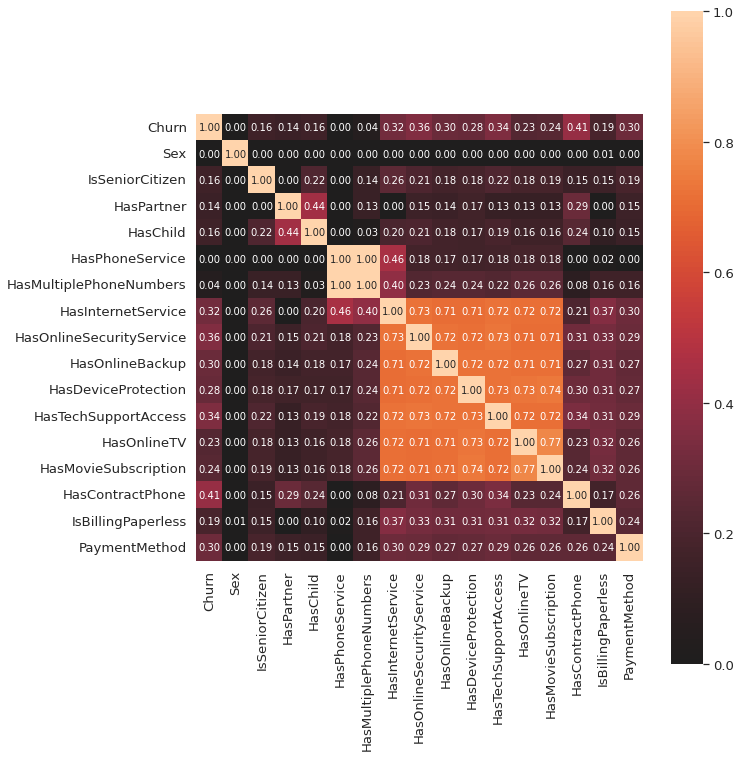

In [31]:
# Measure of association btw cat features 
cat_cols_corr = associations(train[[target_col] + cat_cols], nominal_columns=[target_col]+cat_cols, nom_nom_assoc='cramer', figsize=(10,12))

**Some conclusions**:
* Features such as Sex and HasPhoneService haven't relationship with Target and Other cat_cols, perhaps their feature_importance in Models will be almost Zero. This conclusion can confirm barplots in 'Churn' cut.
* Some cat features'r very similar, but not enough to remove one of them.
* There'r no rare categories

## 2.4 Target col

In [32]:
train.Churn.value_counts()

0    3886
1    1366
Name: Churn, dtype: int64

Classes are not balanced

## 2.5 T-SNE

In [33]:
X_train_cat_sne = train[cat_cols].copy()
X_test_cat_sne = test[cat_cols].copy()
X_train_num_sne = train[num_cols].copy()
X_test_num_sne = test[num_cols].copy()

In [34]:
X_num_sne = pd.concat([X_train_num_sne,X_test_num_sne],ignore_index = True)
X_cat_sne = pd.concat([X_train_cat_sne,X_test_cat_sne],ignore_index = True)
X_num_sne = StandardScaler().fit_transform(X_num_sne)
X_num_sne = pd.DataFrame(data=X_num_sne, columns=num_cols )
X_cat_sne = pd.get_dummies(X_cat_sne,drop_first = True)
X_sne = pd.concat([X_num_sne, X_cat_sne], axis = 1)

In [35]:
label = train['Churn'].map({0:'Churn = 0', 1:'Churn = 1'}).values.tolist() + ['test']*test.shape[0]

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


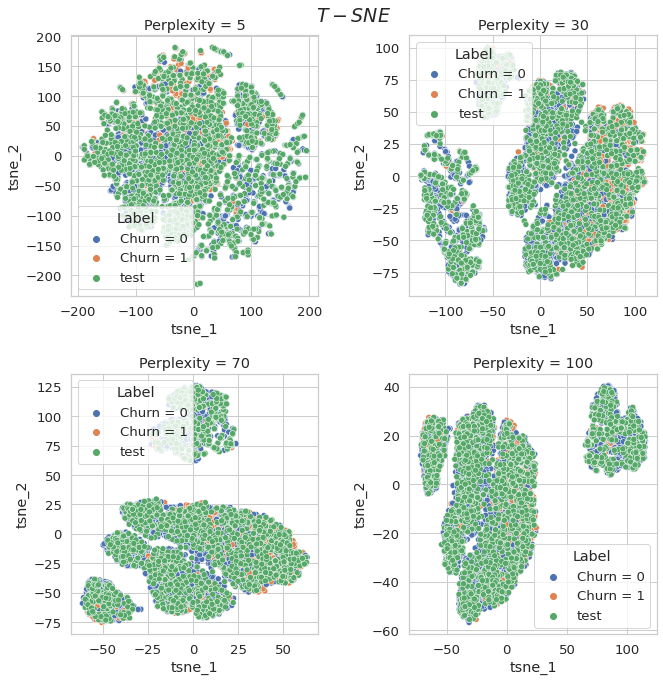

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(9,9))
fig.tight_layout(w_pad = 5, h_pad = 5)
fig.suptitle(r'$T-SNE$', y=1.02, fontsize=19)
perplexity_values = [5, 30, 70, 100] 
for i, perplx in enumerate(perplexity_values):
    tsne = TSNE(n_components = 2, perplexity=perplx, n_iter=3000)
    tsne_result = tsne.fit_transform(X_sne)
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'Label': label})
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='Label', palette = 'deep', data=tsne_result_df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Perplexity = {perplx}')

# <center> 3. Modelling

## 3.1 Logistic Regression

In [43]:
# Class for choosing Scaler (numerical features)

class ChooseScaler(object):
    
    def __init__(self):
        self.std_scl = StandardScaler()
        self.rob_scl = RobustScaler()
        self.mnx_scl = MinMaxScaler()
    
    def fit(self, X,sclr):
        '''
        Fit transformer for numerical features
        :param X: Train set
        :param sclr: Scaler type
        '''
        self.sclr = sclr
        if self.sclr == 'StandardScaler':
            self.std_scl.fit(X)
            return self
        elif self.sclr == 'MinMaxScaler':
            self.mnx_scl.fit(X)
            return self
        else: 
            self.rob_scl.fit(X)
        return self

    def transform(self,X):
        '''
        Transformer
        :param X: Set for transforming
        '''
        if self.sclr == 'StandardScaler':
            return self.std_scl.transform(X)
        elif self.sclr == 'MinMaxScaler':
            return self.mnx_scl.transform
        else:
            return self.rob_scl.transform(X)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [44]:
# Class for choosing Encoder (categorical features)

class ChooseEncoder(object):

    def __init__(self):
        self.ohe_enc = OneHotEncoder(handle_unknown = 'ignore')
        self.lbl_encdrs = {}
    
    def fit(self, X, encd):
        '''
        Fit transformer for categorical features
        :param X: Traing set
        :param sclr: Transformer type
        '''        
        self.encd = encd
        if self.encd == 'LabelEncoder':
            for i in X.columns:
                self.lbl_encdrs[i] = LabelEncoder().fit(X[i])
            return self
        else: 
            self.ohe_enc.fit(X)
            return self
        
    def transform(self,X):
        '''
        Transformation
        :param X: Set for transforming
        '''        
        if self.encd == 'LabelEncoder':
            df = X.copy()
            for i in X.columns:
                df[i] = self.lbl_encdrs[i].transform(df[i])
            return df
        else:
            return self.ohe_enc.transform(X)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [45]:
def lr_model(X,y):
    '''
    Model fitting with hyperparameters selection: Logistic Regression "C" coef, Scaler, Encoder
    :param X: X_train
    :param y: y_train
    :return: List of Trained model, Trained Feature Transformer, 
             Best cv score, best params & cv scores.
    '''

    LR = LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 20)
    model = Pipeline(steps = [
                # Feature Preparation
                ('feature_preparation', FeatureUnion(transformer_list = [
                        # Numerical Features
                        ('numerical_values', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda train: train.loc[:, num_cols])),
                            ('scaling', ChooseScaler())
                                ])),
                        # Categorical Features
                        ('categorical_values', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda train: train.loc[:, cat_cols])),
                            ('encoding', ChooseEncoder())
                                ]))
                    ])),
                # Model Training
                ('model_fit', LR)
             ]
        )
    params_grid = {'model_fit__C' : np.logspace(-3,3,10),
                   'feature_preparation__numerical_values__scaling__sclr' : ['StandardScaler','RobustScaler','MinMaxScaler'],
                   'feature_preparation__categorical_values__encoding__encd' : ['OneHotEncoder','LabelEncoder']
                   }
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    optimizer = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = cv_skf, n_jobs = -1, refit=True)
    optimizer.fit(X,y)
    best_estimator = optimizer.best_estimator_['model_fit']
    best_transformer = optimizer.best_estimator_['feature_preparation']
    best_score = optimizer.best_score_
    best_params = optimizer.best_params_
    cv_results = optimizer.cv_results_
    return [best_estimator, best_transformer, best_score, best_params,cv_results]

In [46]:
def predict(estimator, transformer, X_test):
    '''
    Test set prediction
    :param estimator: Trained model
    :param transformer: Trained feature transformer
    :param X_test: Test Set
    :return: Churn probability
    '''
    X_test = transformer.transform(X_test)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    return y_predict_proba

In [47]:
def submission(file, predicts):
    '''
    Submission
    '''
    preds = pd.trainFrame({'Id' : np.arange(0,len(predicts)),
                          'Churn' : predicts})
    preds.to_csv(f'{file}.csv', index = False)

In [ ]:
# LR fitting
lr_model = lr_model(train[feature_cols],train[target_col].values)

In [49]:
# Best params
lr_model[3]

{'feature_preparation__categorical_values__encoding__encd': 'OneHotEncoder',
 'feature_preparation__numerical_values__scaling__sclr': 'StandardScaler',
 'model_fit__C': 1000.0}

In [51]:
# Best cv scire
np.round(lr_model[2],4)

0.8439

In [ ]:
preds_lr= predict(lr_model[0], lr_model[1], test)

In [ ]:
# submission('subm_1_lr', preds_lr)

## 3.2 LightGBM

In [53]:
X_train_lgb = train.drop('Churn',axis = 1)
y_train_lgb = train['Churn'].values
X_test_lgb = test.drop('HasPartner', axis=1)
for cat_col in cat_cols:
    if cat_col != 'HasPartner':
        X_train_lgb[cat_col] = X_train_lgb[cat_col].astype('category')
        X_test_lgb[cat_col] = X_test_lgb[cat_col].astype('category')

In [54]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
cat_feats = X_train_lgb.columns[3:].tolist()

In [57]:
dtrain_lgb = lgb.trainset(X_train_lgb, label=y_train_lgb, categorical_feature=cat_feats, free_raw_train=False)
dtest_lgb = lgb.trainset(X_test_lgb, categorical_feature=cat_feats, free_raw_train=False)

AttributeError: ignored

# <center> 4. Применение градиентного бустинга

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count() # Количество Ядер CPU
cores

2

In [ ]:
def status_print(optim_result):
    '''
    '''
    all_models = pd.trainFrame(opt.cv_results_)       
    best_params = pd.Series(opt.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(opt.best_score_, 4),
        opt.best_params_
    ))
      

In [ ]:
def boosting_fit(clf, search_spaces, X, y):
    '''
    '''

    def status_print(optim_result):
        '''
        '''
        all_models = pd.trainFrame(opt.cv_results_)       
        best_params = pd.Series(opt.best_params_)
        print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
            len(all_models),
            np.round(opt.best_score_, 4),
            opt.best_params_
        ))

    roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    opt = BayesSearchCV(clf,
                        search_spaces,
                        scoring=roc_auc,
                        cv=cv_skf,
                        n_iter=100,
                        n_jobs=1,
                        return_train_score=False,
                        refit=True,
                        random_state=42)
    result = opt.fit(X, y)
    return result

In [ ]:
# Классификатор
clf_cat = CatBoostClassifier(thread_count=1,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                         cat_features=cat_cols,
                         #task_type = "GPU"
                        )
# Гиперпараметры 
search_spaces_cat = {'iterations': Integer(10, 1000),
                    'depth': Integer(2, 10),
                    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                    'random_strength': Real(1e-9, 10, 'log-uniform'),
                    'bagging_temperature': Real(0.0, 1.0),
                    'border_count': Integer(1, 255),
                    'l2_leaf_reg': Integer(2, 30),
                    'scale_pos_weight':Real(0.01, 1.0, 'uniform')
                    }

In [ ]:
model_cat = boosting_fit(clf_cat,search_spaces_cat,train[feature_cols],train[target_col].values)

In [ ]:
model_cat.best_params_

OrderedDict([('bagging_temperature', 0.0),
             ('border_count', 255),
             ('depth', 2),
             ('iterations', 753),
             ('l2_leaf_reg', 30),
             ('learning_rate', 0.030440043036440795),
             ('random_strength', 10.0),
             ('scale_pos_weight', 1.0)])

In [ ]:
model_cat.best_score_

0.8492884494409105

In [ ]:
preds_cat = model_cat.best_estimator_.predict_proba(test)[:, 1]

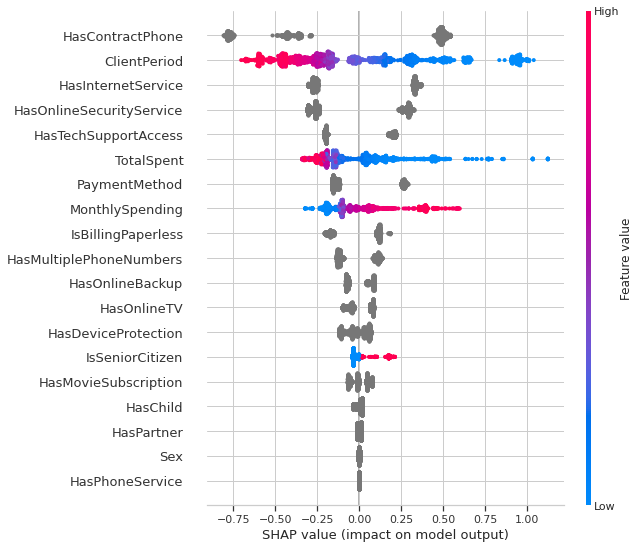

In [ ]:
explainer = shap.TreeExplainer(model_cat.best_estimator_)
shap_values = explainer.shap_values(test)
print('\n')
shap.summary_plot(shap_values, test)

In [ ]:
#submission('subm_2_cat', preds_cat)

**Результаты**
* **CV Score** = *0.8492*

* **Public Score** = *0.85278*

# <center> 5. Kaggle

## 5.1 RF & Feature Engineering

In [ ]:
def rf_fitting(X_train, y_train, X_test):
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42, class_weight = 'balanced')
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_skf, n_jobs=-1, scoring = 'roc_auc')
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)[:,1]
    return [y_predict, np.round(cv_scores,5), np.round(cv_scores.mean(),5), clf]

In [ ]:
def feature_imp(estimator, X, type=''):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X)
    print('\n')
    shap.summary_plot(shap_values, X)

### 5.1.1 RF + LabelEncoder

In [ ]:
X_train_cat_lbl = train[cat_cols].copy()
X_train_num = train[num_cols]
X_test_cat_lbl = test[cat_cols].copy()
X_test_num = test[num_cols]
for cat_col in cat_cols:
    X_train_cat_lbl[cat_col] = LabelEncoder().fit(train[cat_col]).transform(train[cat_col])
    X_test_cat_lbl[cat_col] = LabelEncoder().fit(train[cat_col]).transform(test[cat_col])
X_train_lbl = pd.concat([X_train_num, X_train_cat_lbl], axis = 1)
X_test_lbl = pd.concat([X_test_num, X_test_cat_lbl], axis = 1)
ratio = (train[target_col] == 0).sum() / (train[target_col] == 1).sum()
y_train = train[target_col].values

In [ ]:
results_rf_lbl = rf_fitting(X_train_lbl, y_train, X_test_lbl)
print('cv_scores = ', results_rf_lbl[1],'\n')
print('cv_score = ', results_rf_lbl[2],'\n')
#submission('rf_1_lbl',results_rf_lbl[0])

cv_scores =  [0.82022 0.83443 0.81283 0.82819] 

cv_score =  0.82392 



**Результаты**
* **cv_score_2** = *0.82392*
* **Public Score** = *0.83437*

### 5.1.2 RF + FreqEncoder

In [ ]:
freq_dict = {}
for cat_col in cat_cols:
    freq_df = train[cat_col].value_counts(normalize = True).to_frame().reset_index()
    cat_col_dict = {}
    for i in range(freq_df.shape[0]):
        label = freq_df.iloc[i,0]
        freq = freq_df.iloc[i,1]
        cat_col_dict[label] = freq
        freq_dict[cat_col] = cat_col_dict

X_train_cat_freq = train[cat_cols].copy()
X_test_cat_freq = test[cat_cols].copy()

for cat_col in cat_cols:
    X_train_cat_freq[cat_col] = X_train_cat_freq[cat_col].map(freq_dict[cat_col])
    X_test_cat_freq[cat_col] = X_test_cat_freq[cat_col].map(freq_dict[cat_col])

X_train_freq = pd.concat([X_train_num,X_train_cat_freq], axis = 1)
X_test_freq = pd.concat([X_test_num,X_test_cat_freq], axis = 1)

In [ ]:
results_rf_freq = rf_fitting(X_train_freq, y_train, X_test_freq)
print('cv_scores = ', results_rf_freq[1],'\n')
print('cv_score = ', results_rf_freq[2],'\n')
#submission('rf_0_freq',results_rf_freq[0])

cv_scores =  [0.82152 0.83053 0.81304 0.82947] 

cv_score =  0.82364 



**Результаты**
* **cv_score_2** = *0.82364*
* **Public Score** = *0.83525*

### 5.1.3 RF + OhEncoder


In [ ]:
X_train_cat_ohe = train[cat_cols].copy()
X_test_cat_ohe = test[cat_cols].copy()
X_cat_ohe = pd.concat([X_train_cat_ohe,X_test_cat_ohe],ignore_index = True)
X_cat_ohe = pd.get_dummies(X_cat_ohe,drop_first = True)
X_train_cat_ohe = X_cat_ohe.iloc[:5282,:]
X_test_cat_ohe = X_cat_ohe.iloc[5282:,:].reset_index(drop = True)
X_train_ohe = pd.concat([X_train_num, X_train_cat_ohe], axis = 1)
X_test_ohe = pd.concat([X_test_num, X_test_cat_ohe], axis = 1)

In [ ]:
results_rf_ohe = rf_fitting(X_train_ohe, y_train, X_test_ohe)
print('cv_scores = ', results_rf_ohe[1],'\n')
print('cv_score = ', results_rf_ohe[2],'\n')
#submission('rf_0_ohe',results_rf_ohe[0])

cv_scores =  [0.8193  0.83373 0.81348 0.8315 ] 

cv_score =  0.8245 



**Результаты**
* **cv_score_2** = *0.8245*
* **Public Score** = *0.83206*

### 5.1.4 RF + MeanEncoder

#### 5.1.4.1 Naive ME


In [ ]:
train_cat_me_naive = train[cat_cols + ['Churn']].copy()
X_test_cat_me_naive = test[cat_cols].copy()
for cat_col in cat_cols:
    cat_col_means = train_cat_me_naive.groupby(cat_col)['Churn'].mean()
    train_cat_me_naive[cat_col] = train_cat_me_naive[cat_col].map(cat_col_means)
    X_test_cat_me_naive[cat_col] = X_test_cat_me_naive[cat_col].map(cat_col_means)
X_train_cat_me_naive = train_cat_me_naive[cat_cols]
X_train_me_naive = pd.concat([X_train_num,X_train_cat_me_naive], axis = 1)
X_test_me_naive = pd.concat([X_test_num,X_test_cat_me_naive], axis = 1)

In [ ]:
results_rf_me_naive = rf_fitting(X_train_me_naive, y_train, X_test_me_naive)
print('cv_scores = ', results_rf_me_naive[1],'\n')
print('cv_score = ', results_rf_me_naive[2],'\n')
#submission('rf_0_me_naive',results_rf_me_naive[0])

cv_scores =  [0.82329 0.83371 0.81156 0.82821] 

cv_score =  0.82419 



**Результаты**
* **cv_score_2** = *0.82419*
* **Public Score** = *0.83611*

#### 5.1.4.2 CV ME


In [ ]:
train_cat_me_cv = train[cat_cols + ['Churn']].copy()
X_test_cat_me_cv = test[cat_cols].copy()
X_train_cat_me_cv_new = train_cat_me_cv[cat_cols].copy()
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 10)
for tr_ind, val_ind in skf.split(train_cat_me_cv[cat_cols], y_train):
    X_val = train_cat_me_cv.iloc[val_ind, :]
    X_tr = train_cat_me_cv.iloc[tr_ind, :]
    for cat_col in cat_cols:
        X_train_cat_me_cv_new.loc[val_ind,cat_col + '_enc_new']= X_train_cat_me_cv_new.loc[val_ind, cat_col].map(X_tr.groupby(cat_col)['Churn'].mean())
for col in cat_cols:
    means = X_train_cat_me_cv_new.groupby([col])[col+'_enc_new'].mean()
    train_cat_me_cv[col] = train_cat_me_cv[col].map(means)
    X_test_cat_me_cv[col] = X_test_cat_me_cv[col].map(means)
X_train_cat_me_cv = train_cat_me_cv[cat_cols]
X_train_me_cv = pd.concat([X_train_num,X_train_cat_me_cv], axis = 1)
X_test_me_cv = pd.concat([X_test_num,X_test_cat_me_cv], axis = 1)

In [ ]:
results_rf_me_cv = rf_fitting(X_train_me_cv, y_train, X_test_me_cv)
print('cv_scores = ', results_rf_me_cv[1],'\n')
print('cv_score = ', results_rf_me_cv[2],'\n')
#submission('rf_0_me_cv',results_rf_me_cv[0])

cv_scores =  [0.82329 0.83371 0.81156 0.82821] 

cv_score =  0.82419 



In [ ]:
results_rf_me_cv[0]

array([0.02333333, 0.79333333, 0.24333333, ..., 0.81      , 0.53333333,
       0.00333333])

#### 5.1.4.3 Smooth ME


In [ ]:
train_cat_me_sm = train[cat_cols + ['Churn','ClientPeriod']].copy()
X_test_cat_me_sm = test[cat_cols].copy()
X_train_cat_me_sm = train_cat_me_sm[cat_cols].copy()
alpha = 100
for col in cat_cols:
    global_mean = train_cat_me_sm['Churn'].mean()
    mean = train_cat_me_sm\
                .groupby(col,as_index = False)\
                .agg({'ClientPeriod':'count',
                      'Churn':'mean'})\
                .rename(columns = {'ClientPeriod':'nrows',
                                   'Churn':'target_mean'})
                      
    mean[col + '_sm'] = (mean['nrows']*mean['target_mean'] + global_mean*alpha)/(mean['nrows'] + alpha)
    cat_col_means = mean.groupby(col)[col+'_sm'].mean()
    X_train_cat_me_sm[col] = X_train_cat_me_sm[col].map(cat_col_means)
    X_test_cat_me_sm[col] = X_test_cat_me_sm[col].map(cat_col_means)
X_train_me_sm = pd.concat([X_train_num,X_train_cat_me_sm], axis = 1)
X_test_me_sm = pd.concat([X_test_num,X_test_cat_me_sm], axis = 1)

In [ ]:
results_rf_me_sm = rf_fitting(X_train_me_sm, y_train, X_test_me_sm)
print('cv_scores = ', results_rf_me_sm[1],'\n')
print('cv_score = ', results_rf_me_sm[2],'\n')
#submission('rf_0_me_sm',results_rf_me_sm[0])

cv_scores =  [0.82329 0.83371 0.81156 0.82821] 

cv_score =  0.82419 



### 5.1.5 RF + Freq + T-Sne

In [ ]:
X_train_freq_tsne = pd.concat([X_train_freq,tsne_result_df_100.iloc[:train.shape[0],0]], axis =1 )
X_test_freq_tsne = pd.concat([X_test_freq,tsne_result_df_100.iloc[train.shape[0]:,0].reset_index(drop = True)], axis =1 )

In [ ]:
results_rf_freq_tsne = rf_fitting(X_train_freq_tsne, y_train, X_test_freq_tsne)
print('cv_scores = ', results_rf_freq_tsne[1],'\n')
print('cv_score = ', results_rf_freq_tsne[2],'\n')
#submission('rf_0_freq_tsne',results_rf_freq_tsne[0])

cv_scores =  [0.82142 0.83072 0.81034 0.82711] 

cv_score =  0.8224 



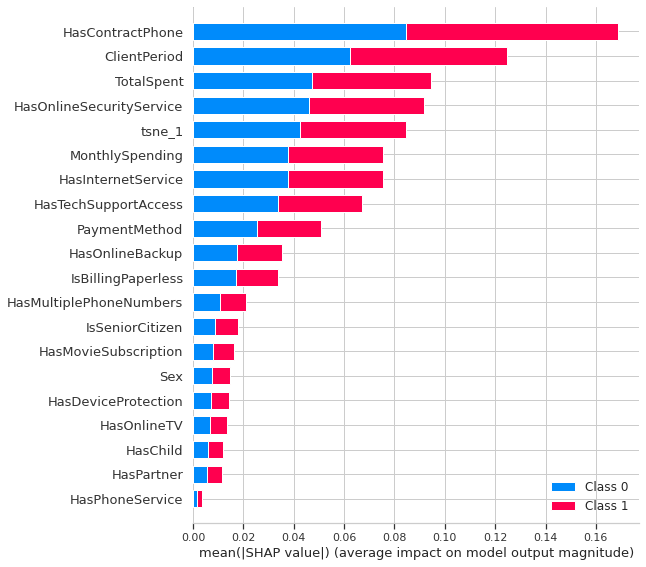

In [ ]:
feature_imp(results_rf_freq_tsne[3], X_test_freq_tsne)

## 5.1 Xgboost

In [ ]:
def xgboost_fitting(X_train, y_train, X_test):
    '''
    '''
    clf_xgb = XGBClassifier(n_estimators = 50,
                          learning_rate = 0.2,
                          n_jobs = 1,                   
                          objective = 'rank:pairwise', 
                          eval_metric = 'auc',           
                          silent=1,                      
                          tree_method='auto' ,
                          scale_pos_weight = ratio 
                        )
    
    search_spaces_xgb = {
                    'min_child_weight': (10, 500),                   
                    'max_depth': (1, 10),                          
                    'subsample': (0.4, 1.0, 'uniform'),           
                    'colsample_bytree': (0.4, 1.0, 'uniform'),     
                    }

    model_xgb = boosting_fit(clf_xgb,search_spaces_xgb,X_train,y_train)

    best_params_xgb = {'n_jobs' : 1,
                       'objective' : 'rank:pairwise',
                       'eval_metric' : 'auc',
                       'silent' : 1,
                       'tree_method' : 'auto',
                       'scale_pos_weight' : ratio,
                       'learning_rate' : 0.05}

    for col in model_xgb.best_params_:
        best_params_xgb[col] = model_xgb.best_params_[col]

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)

    xgbCvResult = xgb.cv(best_params_xgb, dtrain, num_boost_round=2000, nfold=4, stratified = True, early_stopping_rounds=50)

    fig, axes = plt.subplots(1,1, figsize = (10,7))
    sns.lineplot(x = range(xgbCvResult.shape[0]), y = xgbCvResult["test-auc-mean"])
    sns.lineplot(x = range(xgbCvResult.shape[0]), y = xgbCvResult["train-auc-mean"])
    axes.set_title('Valid/Train score')
    axes.set_xlabel('N_Estimators')
    axes.set_ylabel('AUC')

    best_num_round_xgb = np.argmax(xgbCvResult["test-auc-mean"])
    best_params_xgb['n_estimators'] = best_num_round_xgb*2
    best_params_xgb['learning_rate'] = best_params_xgb['learning_rate']/2
    bestXgb = XGBClassifier(**best_params_xgb).fit(X_train, y_train)
    cv_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
    best_cv_scores = cross_val_score(bestXgb, X_train, y_train, n_jobs = -1, cv = cv_skf, scoring = 'roc_auc')
    best_cv_score = best_cv_scores.mean()
    preds_xgb = bestXgb.predict_proba(X_test)[:, 1]
    preds_xgb = MinMaxScaler().fit(pd.Series(preds_xgb).to_frame()).transform(pd.Series(preds_xgb).to_frame()).flatten()

    return [preds_xgb, best_params_xgb, best_cv_scores, best_cv_score, bestXgb]

In [ ]:
def feature_imp(estimator, X):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X)
    print('\n')
    shap.summary_plot(shap_values, X)

In [ ]:
def feature_imp_defolt(estimator, X):
    plt.figure(figsize = (20,50))
    sorted_idx = estimator.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], estimator.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")

**Xgboost + FreqEncoder**

In [ ]:
X_train_freq['Churn'] = y_train

In [ ]:
X_test_freq.shape

(1761, 19)

In [ ]:
X_train_freq.shape

(5282, 20)

Минус дубликаты

In [ ]:
X_train_freq_1 = X_train_freq.drop_duplicates().drop('Churn',axis = 1)
y_train_1 = X_train_freq.drop_duplicates()['Churn'].values

In [ ]:
X_train_freq_1.shape

(5268, 19)

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


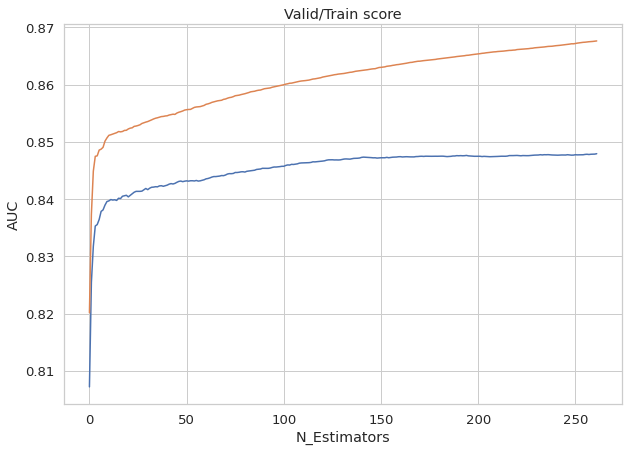

In [ ]:
results_xgb_freq_1 = xgboost_fitting(X_train_freq_1, y_train_1, X_test_freq)

In [ ]:
print(np.round(results_xgb_freq_1[2],5))
print(np.round(results_xgb_freq_1[3],5))

[0.8393  0.85408 0.82741 0.85614]
0.84423


In [ ]:
#submission('xgb_freq_1',results_xgb_freq_1[0])

Минус дубликаты и Sex

In [ ]:
X_train_freq_2 = X_train_freq.drop('Sex', axis=1).drop_duplicates().drop('Churn',axis = 1)
y_data = X_train_freq.drop('Sex', axis=1).drop_duplicates()['Churn'].values
X_test_freq_2 = X_test_freq.drop('Sex', axis=1)

The objective has been evaluated at this point before.


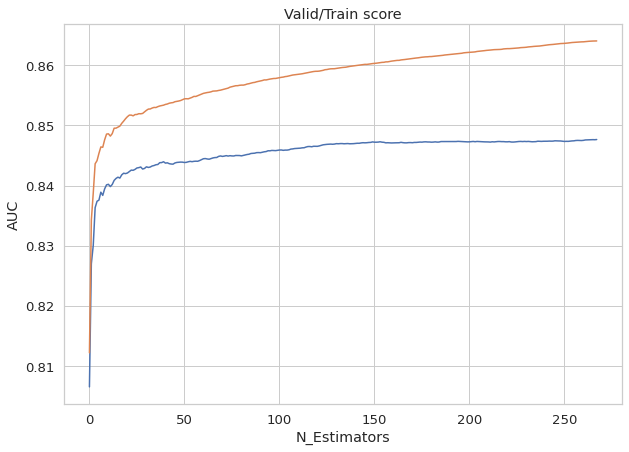

In [ ]:
results_xgb_freq_2 = xgboost_fitting(X_train_freq_2, y_data, X_test_freq_2)

In [ ]:
print(np.round(results_xgb_freq_2[2],5))
print(np.round(results_xgb_freq_2[3],5))

[0.84593 0.84846 0.84744 0.84498]
0.8467


In [ ]:
#submission('xgb_freq_2',results_xgb_freq_2[0])

Минус дубликаты и HasPartner

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


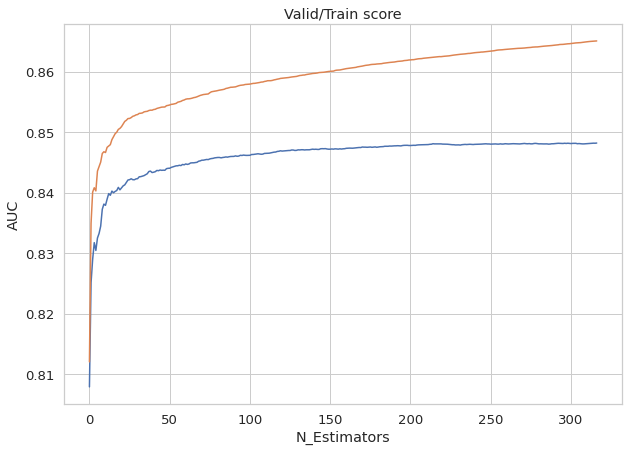

In [ ]:
X_train_freq_3 = X_train_freq.drop('HasPartner', axis=1).drop_duplicates().drop('Churn',axis = 1)
y_train_3 = X_train_freq.drop('HasPartner', axis=1).drop_duplicates()['Churn'].values
X_test_freq_3 = X_test_freq.drop('HasPartner', axis=1)
results_xgb_freq_3 = xgboost_fitting(X_train_freq_3, y_train_3, X_test_freq_3)

In [ ]:
X_train_freq_3.shape

(5268, 18)

In [ ]:
print(np.round(results_xgb_freq_3[2],5))
print(np.round(results_xgb_freq_3[3],5))

[0.83995 0.85492 0.82831 0.85642]
0.8449


In [ ]:
#submission('xgb_freq_3',results_xgb_freq_3[0])

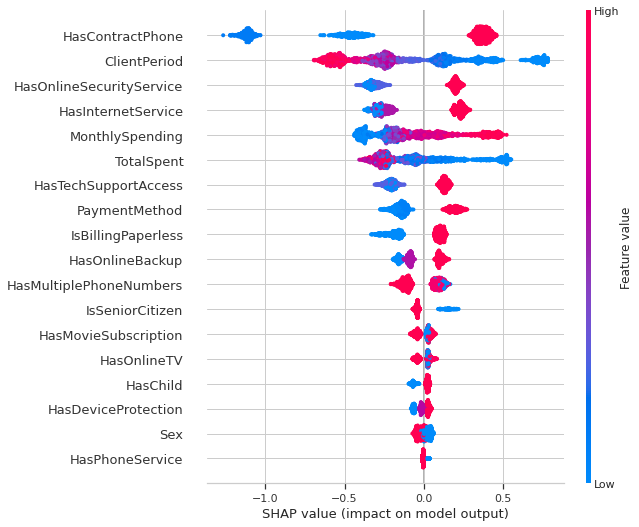

In [ ]:
feature_imp(results_xgb_freq_3[4], X_test_freq_3)

## 5.2 LightGBM

In [ ]:
X_train_lgb = train.drop('HasPartner', axis=1).drop_duplicates().drop('Churn',axis = 1)
y_train_lgb = train.drop('HasPartner', axis=1).drop_duplicates()['Churn'].values
X_test_lgb = test.drop('HasPartner', axis=1)
for cat_col in cat_cols:
    if cat_col != 'HasPartner':
        X_train_lgb[cat_col] = X_train_lgb[cat_col].astype('category')
        X_test_lgb[cat_col] = X_test_lgb[cat_col].astype('category')

In [ ]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)
cat_feats = X_train_lgb.columns[3:].tolist()

In [56]:
dtrain_lgb = lgb.trainset(X_train_lgb, label=y_train_lgb, categorical_feature=cat_feats, free_raw_train=False)
dtest_lgb = lgb.trainset(X_test_lgb, categorical_feature=cat_feats, free_raw_train=False)

AttributeError: ignored

In [ ]:
best_score = 10
training_rounds = 1000
def objective(trial):
    param = {
        "objective": "binary",
        'is_unbalance': 'True',
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500)
        }

    lgbcv = lgb.cv(param,
                    dtrain_lgb,
                    categorical_feature=cat_feats,
                    folds=skf,
                    early_stopping_rounds=100,                   
                    num_boost_round=1000,    
                    verbose_eval=100
                 )
     
    cv_score = lgbcv['auc-mean'][-1]  #- lgbcv['auc-stdv'][-1]
    if cv_score < best_score:
        training_rounds = len(list(lgbcv.values())[0])
    return cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2021-10-18 16:48:22,924] A new study created in memory with name: no-name-e36ad81e-1dc5-46ae-814e-4e15dc500227
[I 2021-10-18 16:48:23,550] Trial 0 finished with value: 0.8443742715831132 and parameters: {'learning_rate': 0.11534802459024635, 'num_leaves': 462, 'feature_fraction': 0.6409107550821618, 'bagging_fraction': 0.8846260771507042, 'min_child_samples': 173}. Best is trial 0 with value: 0.8443742715831132.


[100]	cv_agg's auc: 0.83412 + 0.0116276
[100]	cv_agg's auc: 0.844589 + 0.0109172


[I 2021-10-18 16:48:24,177] Trial 1 finished with value: 0.8453279121484729 and parameters: {'learning_rate': 0.054001758239561305, 'num_leaves': 245, 'feature_fraction': 0.5945566329319341, 'bagging_fraction': 0.6119877780525564, 'min_child_samples': 352}. Best is trial 1 with value: 0.8453279121484729.
[I 2021-10-18 16:48:25,090] Trial 2 finished with value: 0.8392640198501318 and parameters: {'learning_rate': 0.14941640195126657, 'num_leaves': 396, 'feature_fraction': 0.647214611571165, 'bagging_fraction': 0.9916951226989243, 'min_child_samples': 55}. Best is trial 1 with value: 0.8453279121484729.


[100]	cv_agg's auc: 0.820427 + 0.0119588
[100]	cv_agg's auc: 0.843689 + 0.0115364


[I 2021-10-18 16:48:25,886] Trial 3 finished with value: 0.8439021269891284 and parameters: {'learning_rate': 0.040795188904567244, 'num_leaves': 254, 'feature_fraction': 0.8485345800303663, 'bagging_fraction': 0.9759762687701683, 'min_child_samples': 484}. Best is trial 1 with value: 0.8453279121484729.


[200]	cv_agg's auc: 0.843254 + 0.0102955


[I 2021-10-18 16:48:26,843] Trial 4 finished with value: 0.8377886014477103 and parameters: {'learning_rate': 0.08556662914388388, 'num_leaves': 263, 'feature_fraction': 0.9957084538527801, 'bagging_fraction': 0.40640600612603056, 'min_child_samples': 71}. Best is trial 1 with value: 0.8453279121484729.


[100]	cv_agg's auc: 0.82544 + 0.0138288
[100]	cv_agg's auc: 0.844557 + 0.0110961


[I 2021-10-18 16:48:27,452] Trial 5 finished with value: 0.8449456127548067 and parameters: {'learning_rate': 0.06198594376975566, 'num_leaves': 7, 'feature_fraction': 0.6824913361241063, 'bagging_fraction': 0.9127982269238508, 'min_child_samples': 451}. Best is trial 1 with value: 0.8453279121484729.
[I 2021-10-18 16:48:28,259] Trial 6 finished with value: 0.8411657755062588 and parameters: {'learning_rate': 0.16029468431917263, 'num_leaves': 469, 'feature_fraction': 0.8399983466634362, 'bagging_fraction': 0.776495795043113, 'min_child_samples': 91}. Best is trial 1 with value: 0.8453279121484729.


[100]	cv_agg's auc: 0.820959 + 0.0136316


[I 2021-10-18 16:48:28,830] Trial 7 finished with value: 0.8413334054559786 and parameters: {'learning_rate': 0.17074011671404687, 'num_leaves': 240, 'feature_fraction': 0.3701675034209712, 'bagging_fraction': 0.8541998528655177, 'min_child_samples': 106}. Best is trial 1 with value: 0.8453279121484729.


[100]	cv_agg's auc: 0.830454 + 0.0124638


[I 2021-10-18 16:48:29,349] Trial 8 finished with value: 0.8459608068529714 and parameters: {'learning_rate': 0.09854896060141798, 'num_leaves': 255, 'feature_fraction': 0.5252336603690191, 'bagging_fraction': 0.45603617933243523, 'min_child_samples': 281}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842082 + 0.00890135
[100]	cv_agg's auc: 0.844169 + 0.0119449


[I 2021-10-18 16:48:30,097] Trial 9 finished with value: 0.8443152333301767 and parameters: {'learning_rate': 0.02860822215037809, 'num_leaves': 285, 'feature_fraction': 0.3678279748048591, 'bagging_fraction': 0.9840690700767736, 'min_child_samples': 174}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:30,545] Trial 10 finished with value: 0.8439689574905493 and parameters: {'learning_rate': 0.19957285058154733, 'num_leaves': 106, 'feature_fraction': 0.4871347820679882, 'bagging_fraction': 0.40682341304637104, 'min_child_samples': 295}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.837861 + 0.0130401


[I 2021-10-18 16:48:31,051] Trial 11 finished with value: 0.8449669936744107 and parameters: {'learning_rate': 0.10703574107256042, 'num_leaves': 145, 'feature_fraction': 0.5058510320567609, 'bagging_fraction': 0.5812689324190439, 'min_child_samples': 346}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.841246 + 0.0114786
[100]	cv_agg's auc: 0.839948 + 0.0155693
[200]	cv_agg's auc: 0.843233 + 0.0137529
[300]	cv_agg's auc: 0.844528 + 0.0120819
[400]	cv_agg's auc: 0.844864 + 0.0113502


[I 2021-10-18 16:48:32,626] Trial 12 finished with value: 0.8449859849678075 and parameters: {'learning_rate': 0.011714555285353423, 'num_leaves': 351, 'feature_fraction': 0.5150764638176082, 'bagging_fraction': 0.5679320383795334, 'min_child_samples': 375}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:33,223] Trial 13 finished with value: 0.8458807521840328 and parameters: {'learning_rate': 0.06651566959162773, 'num_leaves': 178, 'feature_fraction': 0.5805598634688347, 'bagging_fraction': 0.5065333152316683, 'min_child_samples': 224}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842731 + 0.0106741


[I 2021-10-18 16:48:33,824] Trial 14 finished with value: 0.8451933841995345 and parameters: {'learning_rate': 0.08394538511090535, 'num_leaves': 137, 'feature_fraction': 0.7461291636182561, 'bagging_fraction': 0.31432592732571996, 'min_child_samples': 242}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.841157 + 0.0104457


[I 2021-10-18 16:48:34,294] Trial 15 finished with value: 0.8454333251628854 and parameters: {'learning_rate': 0.1251826656726255, 'num_leaves': 173, 'feature_fraction': 0.4343958427621483, 'bagging_fraction': 0.47281461487398063, 'min_child_samples': 234}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.840117 + 0.0114229


[I 2021-10-18 16:48:34,840] Trial 16 finished with value: 0.8427939087891747 and parameters: {'learning_rate': 0.07506870514262211, 'num_leaves': 67, 'feature_fraction': 0.31236168209159904, 'bagging_fraction': 0.7379299274916207, 'min_child_samples': 162}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.840998 + 0.0117033


[I 2021-10-18 16:48:35,340] Trial 17 finished with value: 0.844618842404203 and parameters: {'learning_rate': 0.1312350341165468, 'num_leaves': 194, 'feature_fraction': 0.5658600045423255, 'bagging_fraction': 0.4936828284908915, 'min_child_samples': 294}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.83981 + 0.0111626


[I 2021-10-18 16:48:35,897] Trial 18 finished with value: 0.8449251387043892 and parameters: {'learning_rate': 0.10001397564257197, 'num_leaves': 328, 'feature_fraction': 0.7462967572997139, 'bagging_fraction': 0.3111745878382601, 'min_child_samples': 415}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.843386 + 0.0116533
[100]	cv_agg's auc: 0.839887 + 0.0157386
[200]	cv_agg's auc: 0.842236 + 0.0144821
[300]	cv_agg's auc: 0.843876 + 0.0130134
[400]	cv_agg's auc: 0.844927 + 0.0120446


[I 2021-10-18 16:48:37,802] Trial 19 finished with value: 0.8450880380887715 and parameters: {'learning_rate': 0.007509443202046412, 'num_leaves': 62, 'feature_fraction': 0.5642753316675286, 'bagging_fraction': 0.6893692010680691, 'min_child_samples': 293}. Best is trial 8 with value: 0.8459608068529714.


[500]	cv_agg's auc: 0.844957 + 0.011461
[100]	cv_agg's auc: 0.825284 + 0.0133407


[I 2021-10-18 16:48:39,371] Trial 20 finished with value: 0.8348234647585671 and parameters: {'learning_rate': 0.06401377235016503, 'num_leaves': 195, 'feature_fraction': 0.4272856905783548, 'bagging_fraction': 0.491929170816353, 'min_child_samples': 13}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:39,851] Trial 21 finished with value: 0.8455202900632844 and parameters: {'learning_rate': 0.13007677512681304, 'num_leaves': 192, 'feature_fraction': 0.45432360291336193, 'bagging_fraction': 0.4765201209758455, 'min_child_samples': 237}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.839233 + 0.0125986


[I 2021-10-18 16:48:40,346] Trial 22 finished with value: 0.8455472466626055 and parameters: {'learning_rate': 0.13978941306025955, 'num_leaves': 307, 'feature_fraction': 0.45521034638804425, 'bagging_fraction': 0.38209494313891174, 'min_child_samples': 212}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.83775 + 0.0119157


[I 2021-10-18 16:48:40,952] Trial 23 finished with value: 0.8452116933730569 and parameters: {'learning_rate': 0.09591789998083156, 'num_leaves': 328, 'feature_fraction': 0.5548335793990504, 'bagging_fraction': 0.3937381842677516, 'min_child_samples': 205}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.839096 + 0.0106851


[I 2021-10-18 16:48:41,501] Trial 24 finished with value: 0.8431310338684601 and parameters: {'learning_rate': 0.14536904227250438, 'num_leaves': 395, 'feature_fraction': 0.38738726120619627, 'bagging_fraction': 0.5430037586383638, 'min_child_samples': 126}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.832417 + 0.0128662


[I 2021-10-18 16:48:41,985] Trial 25 finished with value: 0.845755007377489 and parameters: {'learning_rate': 0.185370103362603, 'num_leaves': 289, 'feature_fraction': 0.6088464590163083, 'bagging_fraction': 0.37902197547087757, 'min_child_samples': 286}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.837569 + 0.0125498


[I 2021-10-18 16:48:42,515] Trial 26 finished with value: 0.8441692875340049 and parameters: {'learning_rate': 0.18020227863607982, 'num_leaves': 378, 'feature_fraction': 0.721558830202488, 'bagging_fraction': 0.6532462538324311, 'min_child_samples': 305}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.838302 + 0.011804
[100]	cv_agg's auc: 0.845338 + 0.0124865


[I 2021-10-18 16:48:43,302] Trial 27 finished with value: 0.8453466384408181 and parameters: {'learning_rate': 0.035533932853736294, 'num_leaves': 225, 'feature_fraction': 0.5996091197392331, 'bagging_fraction': 0.3482054450824168, 'min_child_samples': 266}. Best is trial 8 with value: 0.8459608068529714.


[200]	cv_agg's auc: 0.842912 + 0.0108788


[I 2021-10-18 16:48:43,795] Trial 28 finished with value: 0.8446576409181699 and parameters: {'learning_rate': 0.19886929911677736, 'num_leaves': 284, 'feature_fraction': 0.8033681479295223, 'bagging_fraction': 0.44716220781522326, 'min_child_samples': 339}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.839006 + 0.0117633


[I 2021-10-18 16:48:44,321] Trial 29 finished with value: 0.8439327636178166 and parameters: {'learning_rate': 0.11630666670422249, 'num_leaves': 430, 'feature_fraction': 0.6261867442172497, 'bagging_fraction': 0.5181955961910073, 'min_child_samples': 399}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.841743 + 0.0111177


[I 2021-10-18 16:48:44,889] Trial 30 finished with value: 0.8438601964610206 and parameters: {'learning_rate': 0.11305676536840335, 'num_leaves': 137, 'feature_fraction': 0.5278211516114194, 'bagging_fraction': 0.44344458492308614, 'min_child_samples': 165}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.834438 + 0.0122678


[I 2021-10-18 16:48:45,425] Trial 31 finished with value: 0.8446008806288584 and parameters: {'learning_rate': 0.1472243179923114, 'num_leaves': 301, 'feature_fraction': 0.47181935666446956, 'bagging_fraction': 0.3572140261352916, 'min_child_samples': 192}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.834634 + 0.0108461


[I 2021-10-18 16:48:45,926] Trial 32 finished with value: 0.8442159680490712 and parameters: {'learning_rate': 0.17378297667269132, 'num_leaves': 219, 'feature_fraction': 0.6250790690266788, 'bagging_fraction': 0.36452429003248893, 'min_child_samples': 265}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.836284 + 0.0133767


[I 2021-10-18 16:48:46,425] Trial 33 finished with value: 0.8444066773946914 and parameters: {'learning_rate': 0.18702154279810482, 'num_leaves': 307, 'feature_fraction': 0.5870876808271828, 'bagging_fraction': 0.4297168051249155, 'min_child_samples': 214}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.834848 + 0.0143331


[I 2021-10-18 16:48:46,923] Trial 34 finished with value: 0.8450905484545472 and parameters: {'learning_rate': 0.1595065827168366, 'num_leaves': 342, 'feature_fraction': 0.6617359935512315, 'bagging_fraction': 0.3721007005063696, 'min_child_samples': 323}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.839666 + 0.0123399
[100]	cv_agg's auc: 0.844856 + 0.0102196


[I 2021-10-18 16:48:47,644] Trial 35 finished with value: 0.8456912500306477 and parameters: {'learning_rate': 0.04747324104756305, 'num_leaves': 271, 'feature_fraction': 0.6971648662501292, 'bagging_fraction': 0.6180393356024007, 'min_child_samples': 263}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.844549 + 0.00977874


[I 2021-10-18 16:48:48,280] Trial 36 finished with value: 0.8457153884135058 and parameters: {'learning_rate': 0.056954374957487716, 'num_leaves': 239, 'feature_fraction': 0.6946099466730227, 'bagging_fraction': 0.5937727480907335, 'min_child_samples': 274}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.843667 + 0.0107722


[I 2021-10-18 16:48:48,990] Trial 37 finished with value: 0.8446290237937454 and parameters: {'learning_rate': 0.06984413981180636, 'num_leaves': 228, 'feature_fraction': 0.9366572760290591, 'bagging_fraction': 0.5327194439383353, 'min_child_samples': 368}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.843389 + 0.0102112


[I 2021-10-18 16:48:49,685] Trial 38 finished with value: 0.8449556974587944 and parameters: {'learning_rate': 0.05647507645258121, 'num_leaves': 257, 'feature_fraction': 0.7899671765149868, 'bagging_fraction': 0.6243489458451742, 'min_child_samples': 266}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:50,299] Trial 39 finished with value: 0.8446629791564438 and parameters: {'learning_rate': 0.08337281337846511, 'num_leaves': 171, 'feature_fraction': 0.6617148800178263, 'bagging_fraction': 0.5795286539460753, 'min_child_samples': 136}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.836221 + 0.0116284


[I 2021-10-18 16:48:50,886] Trial 40 finished with value: 0.8452452522436014 and parameters: {'learning_rate': 0.0927162300364238, 'num_leaves': 367, 'feature_fraction': 0.6130666504332283, 'bagging_fraction': 0.6994880672772633, 'min_child_samples': 319}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842632 + 0.0120355
[100]	cv_agg's auc: 0.84465 + 0.0104304


[I 2021-10-18 16:48:51,594] Trial 41 finished with value: 0.845647596095831 and parameters: {'learning_rate': 0.04831593902281132, 'num_leaves': 271, 'feature_fraction': 0.6920823121602551, 'bagging_fraction': 0.6181130503526391, 'min_child_samples': 280}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.845026 + 0.0115929


[I 2021-10-18 16:48:52,498] Trial 42 finished with value: 0.8453239654122069 and parameters: {'learning_rate': 0.02489585784740944, 'num_leaves': 244, 'feature_fraction': 0.6956024161267925, 'bagging_fraction': 0.6494111373876987, 'min_child_samples': 244}. Best is trial 8 with value: 0.8459608068529714.


[200]	cv_agg's auc: 0.844024 + 0.0105422
[100]	cv_agg's auc: 0.845073 + 0.0110478


[I 2021-10-18 16:48:53,250] Trial 43 finished with value: 0.8457771221401397 and parameters: {'learning_rate': 0.03659225025795296, 'num_leaves': 208, 'feature_fraction': 0.6416867494623409, 'bagging_fraction': 0.5528030223537667, 'min_child_samples': 225}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.845118 + 0.0114392


[I 2021-10-18 16:48:54,012] Trial 44 finished with value: 0.8456519550211774 and parameters: {'learning_rate': 0.03685580997149065, 'num_leaves': 505, 'feature_fraction': 0.5439263759476325, 'bagging_fraction': 0.5114991047349938, 'min_child_samples': 227}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:54,661] Trial 45 finished with value: 0.845299762942695 and parameters: {'learning_rate': 0.05535570937458473, 'num_leaves': 215, 'feature_fraction': 0.6479594154271694, 'bagging_fraction': 0.5585322417131434, 'min_child_samples': 180}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.841722 + 0.0100922
[100]	cv_agg's auc: 0.841114 + 0.0150621
[200]	cv_agg's auc: 0.843994 + 0.0119845


[I 2021-10-18 16:48:55,778] Trial 46 finished with value: 0.8442851701792264 and parameters: {'learning_rate': 0.020642001483942827, 'num_leaves': 114, 'feature_fraction': 0.5901653254940246, 'bagging_fraction': 0.4479974833410741, 'min_child_samples': 490}. Best is trial 8 with value: 0.8459608068529714.


[300]	cv_agg's auc: 0.844193 + 0.0107976


[I 2021-10-18 16:48:56,319] Trial 47 finished with value: 0.8455170527091518 and parameters: {'learning_rate': 0.07340902126407459, 'num_leaves': 182, 'feature_fraction': 0.5057422294152308, 'bagging_fraction': 0.82653400158208, 'min_child_samples': 329}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.843655 + 0.011077
[100]	cv_agg's auc: 0.841569 + 0.0100971


[I 2021-10-18 16:48:57,172] Trial 48 finished with value: 0.8438898027578577 and parameters: {'learning_rate': 0.04548732181423086, 'num_leaves': 154, 'feature_fraction': 0.7377916756570118, 'bagging_fraction': 0.41105198584733255, 'min_child_samples': 150}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842535 + 0.0124153
[200]	cv_agg's auc: 0.843183 + 0.0109019


[I 2021-10-18 16:48:58,513] Trial 49 finished with value: 0.8434958346947853 and parameters: {'learning_rate': 0.015881044326129273, 'num_leaves': 108, 'feature_fraction': 0.7864309005622072, 'bagging_fraction': 0.5862149862965558, 'min_child_samples': 193}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:48:59,085] Trial 50 finished with value: 0.8455922824433946 and parameters: {'learning_rate': 0.06193799825553817, 'num_leaves': 251, 'feature_fraction': 0.5759586960035319, 'bagging_fraction': 0.4600282287708375, 'min_child_samples': 282}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.844491 + 0.0108614
[100]	cv_agg's auc: 0.845521 + 0.0112188


[I 2021-10-18 16:48:59,931] Trial 51 finished with value: 0.8456334986596263 and parameters: {'learning_rate': 0.03046565868333257, 'num_leaves': 273, 'feature_fraction': 0.6819115025202438, 'bagging_fraction': 0.6015127787233924, 'min_child_samples': 257}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.84415 + 0.0106096


[I 2021-10-18 16:49:00,630] Trial 52 finished with value: 0.8450638270743724 and parameters: {'learning_rate': 0.04912396058360623, 'num_leaves': 211, 'feature_fraction': 0.7252178421140757, 'bagging_fraction': 0.664953629440401, 'min_child_samples': 304}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:49:01,227] Trial 53 finished with value: 0.8448934900699727 and parameters: {'learning_rate': 0.0831398297384383, 'num_leaves': 292, 'feature_fraction': 0.6372131067158049, 'bagging_fraction': 0.551032205269625, 'min_child_samples': 224}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.840957 + 0.0115305


[I 2021-10-18 16:49:01,885] Trial 54 finished with value: 0.8451721948356425 and parameters: {'learning_rate': 0.06690678274091222, 'num_leaves': 241, 'feature_fraction': 0.6679990324903975, 'bagging_fraction': 0.5007098157988157, 'min_child_samples': 248}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842444 + 0.00960502
[100]	cv_agg's auc: 0.844983 + 0.0104245


[I 2021-10-18 16:49:02,730] Trial 55 finished with value: 0.8450185830393466 and parameters: {'learning_rate': 0.042662154431730534, 'num_leaves': 321, 'feature_fraction': 0.7648919129968674, 'bagging_fraction': 0.7727264434976097, 'min_child_samples': 353}. Best is trial 8 with value: 0.8459608068529714.


[200]	cv_agg's auc: 0.843584 + 0.01112
[100]	cv_agg's auc: 0.8433 + 0.0104822


[I 2021-10-18 16:49:03,419] Trial 56 finished with value: 0.8451206178498382 and parameters: {'learning_rate': 0.06011518664136696, 'num_leaves': 205, 'feature_fraction': 0.8402940133393718, 'bagging_fraction': 0.7054265998033464, 'min_child_samples': 280}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842825 + 0.0103087


[I 2021-10-18 16:49:04,035] Trial 57 finished with value: 0.8446001342188807 and parameters: {'learning_rate': 0.07914329440955609, 'num_leaves': 280, 'feature_fraction': 0.7077543961208813, 'bagging_fraction': 0.9254576039446456, 'min_child_samples': 311}. Best is trial 8 with value: 0.8459608068529714.
[I 2021-10-18 16:49:04,534] Trial 58 finished with value: 0.8458629069071131 and parameters: {'learning_rate': 0.09201900480127558, 'num_leaves': 157, 'feature_fraction': 0.53427895155161, 'bagging_fraction': 0.5263688999866569, 'min_child_samples': 283}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.842136 + 0.01086


[I 2021-10-18 16:49:05,058] Trial 59 finished with value: 0.8448939689592528 and parameters: {'learning_rate': 0.09375501234889137, 'num_leaves': 83, 'feature_fraction': 0.5353088670005519, 'bagging_fraction': 0.4805182949395044, 'min_child_samples': 199}. Best is trial 8 with value: 0.8459608068529714.


[100]	cv_agg's auc: 0.838115 + 0.0104995


[I 2021-10-18 16:49:05,548] Trial 60 finished with value: 0.8460025204724053 and parameters: {'learning_rate': 0.10428702798704326, 'num_leaves': 31, 'feature_fraction': 0.5037446172482237, 'bagging_fraction': 0.4176872465429108, 'min_child_samples': 288}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842703 + 0.0108283


[I 2021-10-18 16:49:06,059] Trial 61 finished with value: 0.8459241286447667 and parameters: {'learning_rate': 0.10631998513172167, 'num_leaves': 40, 'feature_fraction': 0.5039114438644283, 'bagging_fraction': 0.5311525266138922, 'min_child_samples': 294}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.841906 + 0.0106222


[I 2021-10-18 16:49:06,518] Trial 62 finished with value: 0.8457447140123651 and parameters: {'learning_rate': 0.10338997518512037, 'num_leaves': 8, 'feature_fraction': 0.5024973206198193, 'bagging_fraction': 0.41945973561278566, 'min_child_samples': 293}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842301 + 0.0105447


[I 2021-10-18 16:49:06,945] Trial 63 finished with value: 0.8445388926683568 and parameters: {'learning_rate': 0.11987363780799695, 'num_leaves': 23, 'feature_fraction': 0.42435491650606494, 'bagging_fraction': 0.32579829646908387, 'min_child_samples': 358}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842098 + 0.0103934


[I 2021-10-18 16:49:07,416] Trial 64 finished with value: 0.8456303014476833 and parameters: {'learning_rate': 0.10995108330225994, 'num_leaves': 44, 'feature_fraction': 0.4832059927640509, 'bagging_fraction': 0.5347921233642818, 'min_child_samples': 337}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842112 + 0.0108497


[I 2021-10-18 16:49:07,931] Trial 65 finished with value: 0.8456878832042597 and parameters: {'learning_rate': 0.10076605025399928, 'num_leaves': 89, 'feature_fraction': 0.5609368737192612, 'bagging_fraction': 0.47258406718090673, 'min_child_samples': 228}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.83964 + 0.0110282


[I 2021-10-18 16:49:08,384] Trial 66 finished with value: 0.8449361405439482 and parameters: {'learning_rate': 0.08934593144312614, 'num_leaves': 36, 'feature_fraction': 0.5205231370694887, 'bagging_fraction': 0.518761637939264, 'min_child_samples': 457}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.843848 + 0.0114761


[I 2021-10-18 16:49:08,856] Trial 67 finished with value: 0.8459526828875857 and parameters: {'learning_rate': 0.12166474839389117, 'num_leaves': 126, 'feature_fraction': 0.40540677059294905, 'bagging_fraction': 0.388884320927737, 'min_child_samples': 250}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.840282 + 0.0111634


[I 2021-10-18 16:49:09,358] Trial 68 finished with value: 0.8450452799586079 and parameters: {'learning_rate': 0.11919103220132114, 'num_leaves': 160, 'feature_fraction': 0.3375128853904526, 'bagging_fraction': 0.39439876144693875, 'min_child_samples': 248}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.84105 + 0.0106368


[I 2021-10-18 16:49:09,837] Trial 69 finished with value: 0.844526766127589 and parameters: {'learning_rate': 0.1359773929011385, 'num_leaves': 57, 'feature_fraction': 0.3765316388373049, 'bagging_fraction': 0.3366279477446479, 'min_child_samples': 210}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.838644 + 0.0117452


[I 2021-10-18 16:49:10,287] Trial 70 finished with value: 0.8449356675860092 and parameters: {'learning_rate': 0.12387574900272377, 'num_leaves': 127, 'feature_fraction': 0.4180784518003503, 'bagging_fraction': 0.4318504940010923, 'min_child_samples': 381}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842358 + 0.00965647


[I 2021-10-18 16:49:10,802] Trial 71 finished with value: 0.8454507134761422 and parameters: {'learning_rate': 0.10565340594451669, 'num_leaves': 78, 'feature_fraction': 0.45686138213163574, 'bagging_fraction': 0.38768683288199807, 'min_child_samples': 293}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.841601 + 0.0115244


[I 2021-10-18 16:49:11,269] Trial 72 finished with value: 0.8448795886184235 and parameters: {'learning_rate': 0.16295719751854648, 'num_leaves': 167, 'feature_fraction': 0.6012222106732313, 'bagging_fraction': 0.30400643355170937, 'min_child_samples': 308}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.838091 + 0.0120238


[I 2021-10-18 16:49:11,790] Trial 73 finished with value: 0.8456361225033815 and parameters: {'learning_rate': 0.09798015800245198, 'num_leaves': 185, 'feature_fraction': 0.39787585904508715, 'bagging_fraction': 0.45784452174126644, 'min_child_samples': 256}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.841724 + 0.0106587


[I 2021-10-18 16:49:12,307] Trial 74 finished with value: 0.8451076497315856 and parameters: {'learning_rate': 0.11330587176837899, 'num_leaves': 145, 'feature_fraction': 0.5467522775904614, 'bagging_fraction': 0.49175508250537525, 'min_child_samples': 235}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.840098 + 0.0107921


[I 2021-10-18 16:49:12,826] Trial 75 finished with value: 0.8453214850317861 and parameters: {'learning_rate': 0.08819299228156022, 'num_leaves': 124, 'feature_fraction': 0.48307948074449325, 'bagging_fraction': 0.42057691648599344, 'min_child_samples': 287}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842682 + 0.0109011
[100]	cv_agg's auc: 0.844665 + 0.0127061
[200]	cv_agg's auc: 0.844321 + 0.0113864


[I 2021-10-18 16:49:13,270] Trial 76 finished with value: 0.8448124609082994 and parameters: {'learning_rate': 0.153630187660212, 'num_leaves': 2, 'feature_fraction': 0.5725488424107464, 'bagging_fraction': 0.3718365904342864, 'min_child_samples': 269}. Best is trial 60 with value: 0.8460025204724053.
[I 2021-10-18 16:49:13,848] Trial 77 finished with value: 0.84448611996175 and parameters: {'learning_rate': 0.10758261294304432, 'num_leaves': 92, 'feature_fraction': 0.44769152999669737, 'bagging_fraction': 0.528998734477118, 'min_child_samples': 182}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.837402 + 0.0126496


[I 2021-10-18 16:49:14,382] Trial 78 finished with value: 0.8449693856168146 and parameters: {'learning_rate': 0.07890735471056458, 'num_leaves': 48, 'feature_fraction': 0.33959376461916396, 'bagging_fraction': 0.5634160494071161, 'min_child_samples': 218}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842272 + 0.0105954


[I 2021-10-18 16:49:14,853] Trial 79 finished with value: 0.8452644261409236 and parameters: {'learning_rate': 0.13016593811184135, 'num_leaves': 24, 'feature_fraction': 0.6146077584944438, 'bagging_fraction': 0.3465619812133449, 'min_child_samples': 319}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.841154 + 0.0123864


[I 2021-10-18 16:49:15,318] Trial 80 finished with value: 0.8456815365754018 and parameters: {'learning_rate': 0.19046233330841414, 'num_leaves': 231, 'feature_fraction': 0.5027313118339314, 'bagging_fraction': 0.39621252621235076, 'min_child_samples': 303}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.838022 + 0.0113738


[I 2021-10-18 16:49:15,816] Trial 81 finished with value: 0.8456478047569672 and parameters: {'learning_rate': 0.09673202673487664, 'num_leaves': 18, 'feature_fraction': 0.49301405942657756, 'bagging_fraction': 0.4328532658294206, 'min_child_samples': 290}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842139 + 0.010956


[I 2021-10-18 16:49:16,311] Trial 82 finished with value: 0.8454363627137685 and parameters: {'learning_rate': 0.10504317354678133, 'num_leaves': 70, 'feature_fraction': 0.5210172024447695, 'bagging_fraction': 0.4183865720226499, 'min_child_samples': 253}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.840024 + 0.0106834


[I 2021-10-18 16:49:16,810] Trial 83 finished with value: 0.8459085649466167 and parameters: {'learning_rate': 0.10177112795694408, 'num_leaves': 12, 'feature_fraction': 0.46955585842477654, 'bagging_fraction': 0.4639927339502236, 'min_child_samples': 333}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842743 + 0.0119303


[I 2021-10-18 16:49:17,310] Trial 84 finished with value: 0.8454169406078195 and parameters: {'learning_rate': 0.09145680735516043, 'num_leaves': 196, 'feature_fraction': 0.46297004849527645, 'bagging_fraction': 0.5045462016786857, 'min_child_samples': 332}. Best is trial 60 with value: 0.8460025204724053.


[100]	cv_agg's auc: 0.842951 + 0.0108592


[I 2021-10-18 16:49:17,817] Trial 85 finished with value: 0.8461517955819715 and parameters: {'learning_rate': 0.10959519928652575, 'num_leaves': 30, 'feature_fraction': 0.5360147652479166, 'bagging_fraction': 0.46897110962175087, 'min_child_samples': 276}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841561 + 0.00969247


[I 2021-10-18 16:49:18,265] Trial 86 finished with value: 0.8455963953824107 and parameters: {'learning_rate': 0.1236094883328703, 'num_leaves': 29, 'feature_fraction': 0.40779639260657813, 'bagging_fraction': 0.4793542858433629, 'min_child_samples': 274}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841734 + 0.0106634


[I 2021-10-18 16:49:18,786] Trial 87 finished with value: 0.8453035488128531 and parameters: {'learning_rate': 0.11430049755922929, 'num_leaves': 58, 'feature_fraction': 0.44334557670258723, 'bagging_fraction': 0.45513892496452085, 'min_child_samples': 236}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840564 + 0.011411


[I 2021-10-18 16:49:19,264] Trial 88 finished with value: 0.8451774445419997 and parameters: {'learning_rate': 0.1355239407972618, 'num_leaves': 99, 'feature_fraction': 0.5336758958403547, 'bagging_fraction': 0.5420671735638405, 'min_child_samples': 349}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840965 + 0.0113098


[I 2021-10-18 16:49:19,734] Trial 89 finished with value: 0.845370215020821 and parameters: {'learning_rate': 0.11810030285978275, 'num_leaves': 13, 'feature_fraction': 0.46649640855619356, 'bagging_fraction': 0.46740295410099586, 'min_child_samples': 314}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84115 + 0.0113277


[I 2021-10-18 16:49:20,235] Trial 90 finished with value: 0.8458407628790064 and parameters: {'learning_rate': 0.1113043236285042, 'num_leaves': 39, 'feature_fraction': 0.5593867277985821, 'bagging_fraction': 0.4898900702955729, 'min_child_samples': 265}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84114 + 0.0110391


[I 2021-10-18 16:49:20,766] Trial 91 finished with value: 0.8455956879095745 and parameters: {'learning_rate': 0.10967181551949022, 'num_leaves': 38, 'feature_fraction': 0.5506018828082693, 'bagging_fraction': 0.4993919652493569, 'min_child_samples': 243}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840194 + 0.0111752


[I 2021-10-18 16:49:21,305] Trial 92 finished with value: 0.8454097209137241 and parameters: {'learning_rate': 0.09855862692114739, 'num_leaves': 70, 'feature_fraction': 0.5749298870178718, 'bagging_fraction': 0.48512848592729285, 'min_child_samples': 258}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841097 + 0.0106158


[I 2021-10-18 16:49:21,786] Trial 93 finished with value: 0.8456205326541206 and parameters: {'learning_rate': 0.12634991882260965, 'num_leaves': 48, 'feature_fraction': 0.5168071813537984, 'bagging_fraction': 0.5194921651067128, 'min_child_samples': 278}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841105 + 0.0102198


[I 2021-10-18 16:49:22,618] Trial 94 finished with value: 0.8409377304812724 and parameters: {'learning_rate': 0.11130280147675044, 'num_leaves': 180, 'feature_fraction': 0.48041468824025124, 'bagging_fraction': 0.578533158910647, 'min_child_samples': 54}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.825628 + 0.0144475


[I 2021-10-18 16:49:23,148] Trial 95 finished with value: 0.8456645987780176 and parameters: {'learning_rate': 0.10178547897009986, 'num_leaves': 29, 'feature_fraction': 0.5852903108944296, 'bagging_fraction': 0.44742707760241196, 'min_child_samples': 265}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841794 + 0.0107412


[I 2021-10-18 16:49:23,675] Trial 96 finished with value: 0.8456893621270362 and parameters: {'learning_rate': 0.08742311860171055, 'num_leaves': 152, 'feature_fraction': 0.5405714181403332, 'bagging_fraction': 0.5501539620420234, 'min_child_samples': 298}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842167 + 0.0111051
[100]	cv_agg's auc: 0.842448 + 0.0142556
[200]	cv_agg's auc: 0.844485 + 0.012666


[I 2021-10-18 16:49:24,353] Trial 97 finished with value: 0.8448478619062743 and parameters: {'learning_rate': 0.0800035389827221, 'num_leaves': 2, 'feature_fraction': 0.5010373715072677, 'bagging_fraction': 0.5063965647711515, 'min_child_samples': 327}. Best is trial 85 with value: 0.8461517955819715.


[300]	cv_agg's auc: 0.844675 + 0.0121056


[I 2021-10-18 16:49:24,968] Trial 98 finished with value: 0.8457134490997216 and parameters: {'learning_rate': 0.07008951974065304, 'num_leaves': 203, 'feature_fraction': 0.5635753725805228, 'bagging_fraction': 0.4431148451442177, 'min_child_samples': 223}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842815 + 0.0109798


[I 2021-10-18 16:49:25,469] Trial 99 finished with value: 0.8451093144821826 and parameters: {'learning_rate': 0.09574719774515407, 'num_leaves': 134, 'feature_fraction': 0.4367578766834151, 'bagging_fraction': 0.5253300760913149, 'min_child_samples': 205}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840346 + 0.0106306


[I 2021-10-18 16:49:25,958] Trial 100 finished with value: 0.8450602394111666 and parameters: {'learning_rate': 0.12141249129088125, 'num_leaves': 53, 'feature_fraction': 0.6269961552377221, 'bagging_fraction': 0.4093888999165358, 'min_child_samples': 275}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.83929 + 0.0106693


[I 2021-10-18 16:49:26,471] Trial 101 finished with value: 0.8452198126121496 and parameters: {'learning_rate': 0.10222266561319346, 'num_leaves': 35, 'feature_fraction': 0.5317534137860987, 'bagging_fraction': 0.37811834158484875, 'min_child_samples': 288}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841497 + 0.0101927


[I 2021-10-18 16:49:27,001] Trial 102 finished with value: 0.8458129415558855 and parameters: {'learning_rate': 0.11709372084554076, 'num_leaves': 115, 'feature_fraction': 0.589351982393211, 'bagging_fraction': 0.46189319264291673, 'min_child_samples': 243}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840385 + 0.0122909


[I 2021-10-18 16:49:27,539] Trial 103 finished with value: 0.8454469993454765 and parameters: {'learning_rate': 0.11686126038605119, 'num_leaves': 115, 'feature_fraction': 0.5940030602334567, 'bagging_fraction': 0.46313394300194277, 'min_child_samples': 242}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.83981 + 0.0112894


[I 2021-10-18 16:49:28,039] Trial 104 finished with value: 0.8455784871299856 and parameters: {'learning_rate': 0.12677963103528414, 'num_leaves': 160, 'feature_fraction': 0.5559079133146415, 'bagging_fraction': 0.49231270159014123, 'min_child_samples': 232}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.838532 + 0.0122915


[I 2021-10-18 16:49:28,592] Trial 105 finished with value: 0.8458666291914166 and parameters: {'learning_rate': 0.11025988308054403, 'num_leaves': 78, 'feature_fraction': 0.6114285993516926, 'bagging_fraction': 0.4362774032653579, 'min_child_samples': 253}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841088 + 0.0114229


[I 2021-10-18 16:49:29,106] Trial 106 finished with value: 0.8452102936235114 and parameters: {'learning_rate': 0.10787541105086412, 'num_leaves': 81, 'feature_fraction': 0.5107291089800549, 'bagging_fraction': 0.4026675596219866, 'min_child_samples': 261}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84045 + 0.0108445


[I 2021-10-18 16:49:29,617] Trial 107 finished with value: 0.845181709692687 and parameters: {'learning_rate': 0.11300661317783814, 'num_leaves': 63, 'feature_fraction': 0.5833556393220676, 'bagging_fraction': 0.4368772339766291, 'min_child_samples': 302}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840589 + 0.0114043


[I 2021-10-18 16:49:30,158] Trial 108 finished with value: 0.8456718277368989 and parameters: {'learning_rate': 0.09283482500497203, 'num_leaves': 114, 'feature_fraction': 0.47372761696835525, 'bagging_fraction': 0.4688315526655238, 'min_child_samples': 270}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84231 + 0.0102


[I 2021-10-18 16:49:30,661] Trial 109 finished with value: 0.8450088016632028 and parameters: {'learning_rate': 0.13908634063137962, 'num_leaves': 100, 'feature_fraction': 0.6067900829375982, 'bagging_fraction': 0.48296773231754486, 'min_child_samples': 248}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.838631 + 0.0121579


[I 2021-10-18 16:49:31,149] Trial 110 finished with value: 0.8453500784151962 and parameters: {'learning_rate': 0.10576998541195637, 'num_leaves': 16, 'feature_fraction': 0.5506761850689137, 'bagging_fraction': 0.4304151823238469, 'min_child_samples': 339}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842324 + 0.0119422


[I 2021-10-18 16:49:31,727] Trial 111 finished with value: 0.845256687916158 and parameters: {'learning_rate': 0.10062525780953162, 'num_leaves': 145, 'feature_fraction': 0.6194227511778513, 'bagging_fraction': 0.508890745433621, 'min_child_samples': 219}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839421 + 0.0115434


[I 2021-10-18 16:49:32,294] Trial 112 finished with value: 0.8444925261544185 and parameters: {'learning_rate': 0.11077750782474687, 'num_leaves': 43, 'feature_fraction': 0.6390742564096163, 'bagging_fraction': 0.45715026663271385, 'min_child_samples': 191}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.83716 + 0.0121272


[I 2021-10-18 16:49:32,896] Trial 113 finished with value: 0.8449293382660252 and parameters: {'learning_rate': 0.11791781098711059, 'num_leaves': 72, 'feature_fraction': 0.8969303951278578, 'bagging_fraction': 0.5684647964806178, 'min_child_samples': 257}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839243 + 0.0120001


[I 2021-10-18 16:49:33,412] Trial 114 finished with value: 0.844327443379219 and parameters: {'learning_rate': 0.11473694650565469, 'num_leaves': 133, 'feature_fraction': 0.670706232936762, 'bagging_fraction': 0.5404663482289782, 'min_child_samples': 281}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839637 + 0.0118204


[I 2021-10-18 16:49:33,972] Trial 115 finished with value: 0.8459646338669176 and parameters: {'learning_rate': 0.10538946838005883, 'num_leaves': 124, 'feature_fraction': 0.5310222993481768, 'bagging_fraction': 0.4796838352098792, 'min_child_samples': 238}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840383 + 0.0109142


[I 2021-10-18 16:49:34,527] Trial 116 finished with value: 0.8451338269151284 and parameters: {'learning_rate': 0.10540785616652387, 'num_leaves': 427, 'feature_fraction': 0.4949613407973804, 'bagging_fraction': 0.4189000641887061, 'min_child_samples': 313}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841791 + 0.0110375


[I 2021-10-18 16:49:35,019] Trial 117 finished with value: 0.8451768960259743 and parameters: {'learning_rate': 0.13217204056918516, 'num_leaves': 93, 'feature_fraction': 0.5233647419498044, 'bagging_fraction': 0.4740749724310201, 'min_child_samples': 240}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839063 + 0.0110934


[I 2021-10-18 16:49:35,545] Trial 118 finished with value: 0.8454278965772972 and parameters: {'learning_rate': 0.12193172487316242, 'num_leaves': 117, 'feature_fraction': 0.5703982410914261, 'bagging_fraction': 0.44983438027876244, 'min_child_samples': 248}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839588 + 0.0120201


[I 2021-10-18 16:49:36,073] Trial 119 finished with value: 0.8452997374958333 and parameters: {'learning_rate': 0.09650056873014498, 'num_leaves': 106, 'feature_fraction': 0.5146656163637415, 'bagging_fraction': 0.49686356132336995, 'min_child_samples': 266}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841093 + 0.0104955


[I 2021-10-18 16:49:36,589] Trial 120 finished with value: 0.8457101009750555 and parameters: {'learning_rate': 0.0835389839116984, 'num_leaves': 57, 'feature_fraction': 0.5358169542642853, 'bagging_fraction': 0.40380496329152143, 'min_child_samples': 296}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842715 + 0.0108692
[100]	cv_agg's auc: 0.844193 + 0.0106314


[I 2021-10-18 16:49:37,280] Trial 121 finished with value: 0.8456000686666381 and parameters: {'learning_rate': 0.052335318107508924, 'num_leaves': 168, 'feature_fraction': 0.5922904620579239, 'bagging_fraction': 0.5187458236590153, 'min_child_samples': 231}. Best is trial 85 with value: 0.8461517955819715.
[I 2021-10-18 16:49:37,819] Trial 122 finished with value: 0.8455680969854071 and parameters: {'learning_rate': 0.10811085853004661, 'num_leaves': 140, 'feature_fraction': 0.5602741569793431, 'bagging_fraction': 0.48457053969267916, 'min_child_samples': 210}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839699 + 0.0106453


[I 2021-10-18 16:49:38,358] Trial 123 finished with value: 0.845077304771509 and parameters: {'learning_rate': 0.10265559340612418, 'num_leaves': 127, 'feature_fraction': 0.4895082665558605, 'bagging_fraction': 0.466210026289122, 'min_child_samples': 252}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841333 + 0.0105239
[100]	cv_agg's auc: 0.8414 + 0.0147243
[200]	cv_agg's auc: 0.842793 + 0.0137956
[300]	cv_agg's auc: 0.843957 + 0.0131816
[400]	cv_agg's auc: 0.844392 + 0.0125698


[I 2021-10-18 16:49:40,250] Trial 124 finished with value: 0.8445354093278941 and parameters: {'learning_rate': 0.007548876663096241, 'num_leaves': 30, 'feature_fraction': 0.3525247074022085, 'bagging_fraction': 0.43579058306292356, 'min_child_samples': 200}. Best is trial 85 with value: 0.8461517955819715.


[500]	cv_agg's auc: 0.844385 + 0.0121274


[I 2021-10-18 16:49:40,816] Trial 125 finished with value: 0.8450111061848379 and parameters: {'learning_rate': 0.09167634526672787, 'num_leaves': 13, 'feature_fraction': 0.64921017313703, 'bagging_fraction': 0.5308723999761913, 'min_child_samples': 218}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839942 + 0.0118596


[I 2021-10-18 16:49:41,324] Trial 126 finished with value: 0.8454432218324059 and parameters: {'learning_rate': 0.11485966616590547, 'num_leaves': 175, 'feature_fraction': 0.632278699913178, 'bagging_fraction': 0.5072615486135935, 'min_child_samples': 283}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840477 + 0.0113295
[100]	cv_agg's auc: 0.844902 + 0.0120818


[I 2021-10-18 16:49:42,031] Trial 127 finished with value: 0.8450516847427785 and parameters: {'learning_rate': 0.037385216384064134, 'num_leaves': 153, 'feature_fraction': 0.5778517774957319, 'bagging_fraction': 0.5503622098769634, 'min_child_samples': 365}. Best is trial 85 with value: 0.8461517955819715.
[I 2021-10-18 16:49:42,531] Trial 128 finished with value: 0.8448422144088152 and parameters: {'learning_rate': 0.12850232904164124, 'num_leaves': 189, 'feature_fraction': 0.6037665785483097, 'bagging_fraction': 0.3626069249591411, 'min_child_samples': 270}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839597 + 0.0110621


[I 2021-10-18 16:49:43,100] Trial 129 finished with value: 0.8456416027025919 and parameters: {'learning_rate': 0.09943370815907006, 'num_leaves': 77, 'feature_fraction': 0.5395252489544696, 'bagging_fraction': 0.5985029403260239, 'min_child_samples': 230}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839931 + 0.0121563


[I 2021-10-18 16:49:43,663] Trial 130 finished with value: 0.8431832773867625 and parameters: {'learning_rate': 0.10999976488736739, 'num_leaves': 256, 'feature_fraction': 0.5215623059186738, 'bagging_fraction': 0.4503329146169049, 'min_child_samples': 166}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.834614 + 0.011542


[I 2021-10-18 16:49:44,167] Trial 131 finished with value: 0.8448154183782528 and parameters: {'learning_rate': 0.16864124317880996, 'num_leaves': 298, 'feature_fraction': 0.6139721032947281, 'bagging_fraction': 0.35027543282263685, 'min_child_samples': 287}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.83777 + 0.0127914
[100]	cv_agg's auc: 0.843095 + 0.0131101
[200]	cv_agg's auc: 0.844347 + 0.0112535


[I 2021-10-18 16:49:45,061] Trial 132 finished with value: 0.8444543690077874 and parameters: {'learning_rate': 0.025845033142595956, 'num_leaves': 23, 'feature_fraction': 0.3010543356288298, 'bagging_fraction': 0.3775221380148124, 'min_child_samples': 258}. Best is trial 85 with value: 0.8461517955819715.
[I 2021-10-18 16:49:45,606] Trial 133 finished with value: 0.8453189819119495 and parameters: {'learning_rate': 0.07533109173320543, 'num_leaves': 218, 'feature_fraction': 0.5647445630141131, 'bagging_fraction': 0.39257301992149174, 'min_child_samples': 321}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.843967 + 0.0116236


[I 2021-10-18 16:49:46,068] Trial 134 finished with value: 0.844695368363397 and parameters: {'learning_rate': 0.1794929398859788, 'num_leaves': 308, 'feature_fraction': 0.5480248240674066, 'bagging_fraction': 0.42805845510675106, 'min_child_samples': 388}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.839269 + 0.011699


[I 2021-10-18 16:49:46,559] Trial 135 finished with value: 0.8449620972036724 and parameters: {'learning_rate': 0.08712611337526177, 'num_leaves': 45, 'feature_fraction': 0.5980381079618095, 'bagging_fraction': 0.47764915135982167, 'min_child_samples': 274}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84212 + 0.0105582


[I 2021-10-18 16:49:47,073] Trial 136 finished with value: 0.8459206393729628 and parameters: {'learning_rate': 0.10434225845106021, 'num_leaves': 36, 'feature_fraction': 0.5035363207530379, 'bagging_fraction': 0.4139499842763731, 'min_child_samples': 306}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.84193 + 0.0110256


[I 2021-10-18 16:49:47,595] Trial 137 finished with value: 0.8456019192450557 and parameters: {'learning_rate': 0.10354183524243403, 'num_leaves': 34, 'feature_fraction': 0.5073074186778243, 'bagging_fraction': 0.6360906396347015, 'min_child_samples': 306}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841887 + 0.0106039


[I 2021-10-18 16:49:48,085] Trial 138 finished with value: 0.8450940459738887 and parameters: {'learning_rate': 0.09628365429662751, 'num_leaves': 9, 'feature_fraction': 0.4762553480052363, 'bagging_fraction': 0.41256147165637735, 'min_child_samples': 297}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842723 + 0.0109158


[I 2021-10-18 16:49:48,571] Trial 139 finished with value: 0.8450347574152286 and parameters: {'learning_rate': 0.1185110325233618, 'num_leaves': 65, 'feature_fraction': 0.4546527875435314, 'bagging_fraction': 0.493194776488161, 'min_child_samples': 241}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.840256 + 0.0113555


[I 2021-10-18 16:49:49,066] Trial 140 finished with value: 0.8446511255669157 and parameters: {'learning_rate': 0.10867849589605395, 'num_leaves': 45, 'feature_fraction': 0.49161248792470297, 'bagging_fraction': 0.45588978171435496, 'min_child_samples': 325}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841262 + 0.0119869


[I 2021-10-18 16:49:49,602] Trial 141 finished with value: 0.8457917249297344 and parameters: {'learning_rate': 0.09939421824658774, 'num_leaves': 18, 'feature_fraction': 0.5293648294150891, 'bagging_fraction': 0.3880252418466002, 'min_child_samples': 283}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841067 + 0.00906088


[I 2021-10-18 16:49:50,123] Trial 142 finished with value: 0.8453214915734762 and parameters: {'learning_rate': 0.10003201845517723, 'num_leaves': 37, 'feature_fraction': 0.5288544638398515, 'bagging_fraction': 0.4364687523308225, 'min_child_samples': 283}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.841557 + 0.0100248


[I 2021-10-18 16:49:50,617] Trial 143 finished with value: 0.8460071831324949 and parameters: {'learning_rate': 0.10519727554012687, 'num_leaves': 22, 'feature_fraction': 0.5128621476911526, 'bagging_fraction': 0.38826150866355663, 'min_child_samples': 313}. Best is trial 85 with value: 0.8461517955819715.


[100]	cv_agg's auc: 0.842335 + 0.0108499


[I 2021-10-18 16:49:51,126] Trial 144 finished with value: 0.8462513372416615 and parameters: {'learning_rate': 0.10552425712614882, 'num_leaves': 18, 'feature_fraction': 0.5074998235184829, 'bagging_fraction': 0.3962035072695082, 'min_child_samples': 312}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841749 + 0.0103058
[100]	cv_agg's auc: 0.843903 + 0.0132669
[200]	cv_agg's auc: 0.844557 + 0.012235


[I 2021-10-18 16:49:51,629] Trial 145 finished with value: 0.8448556042626336 and parameters: {'learning_rate': 0.11385609476874307, 'num_leaves': 2, 'feature_fraction': 0.5077196773384303, 'bagging_fraction': 0.3288307472713712, 'min_child_samples': 313}. Best is trial 144 with value: 0.8462513372416615.
[I 2021-10-18 16:49:52,100] Trial 146 finished with value: 0.8443986698338306 and parameters: {'learning_rate': 0.10704443013158922, 'num_leaves': 55, 'feature_fraction': 0.4651662134394853, 'bagging_fraction': 0.36262290860175117, 'min_child_samples': 343}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.84147 + 0.0107736


[I 2021-10-18 16:49:52,588] Trial 147 finished with value: 0.8457128854971189 and parameters: {'learning_rate': 0.11156299887083031, 'num_leaves': 22, 'feature_fraction': 0.5503162539606165, 'bagging_fraction': 0.40781313448200407, 'min_child_samples': 329}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841771 + 0.0115432


[I 2021-10-18 16:49:53,096] Trial 148 finished with value: 0.8456461395994708 and parameters: {'learning_rate': 0.0931544818960215, 'num_leaves': 26, 'feature_fraction': 0.5018165138588973, 'bagging_fraction': 0.41923671996199746, 'min_child_samples': 305}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842117 + 0.0106873


[I 2021-10-18 16:49:53,570] Trial 149 finished with value: 0.8453632439266019 and parameters: {'learning_rate': 0.1232870254845087, 'num_leaves': 13, 'feature_fraction': 0.5195622170271623, 'bagging_fraction': 0.4633626770216945, 'min_child_samples': 292}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840738 + 0.0102238


[I 2021-10-18 16:49:54,068] Trial 150 finished with value: 0.8451894240825386 and parameters: {'learning_rate': 0.10444815470957176, 'num_leaves': 88, 'feature_fraction': 0.48259250586161284, 'bagging_fraction': 0.3857553805011951, 'min_child_samples': 316}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842259 + 0.0110316


[I 2021-10-18 16:49:54,596] Trial 151 finished with value: 0.8455093560350736 and parameters: {'learning_rate': 0.09992482109761534, 'num_leaves': 17, 'feature_fraction': 0.5345903826420042, 'bagging_fraction': 0.40137110453029456, 'min_child_samples': 264}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841117 + 0.0104602


[I 2021-10-18 16:49:55,103] Trial 152 finished with value: 0.8453041124154557 and parameters: {'learning_rate': 0.116178422129449, 'num_leaves': 38, 'feature_fraction': 0.5290881485490063, 'bagging_fraction': 0.38357212662332424, 'min_child_samples': 298}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841308 + 0.0111151


[I 2021-10-18 16:49:55,648] Trial 153 finished with value: 0.8458114540725719 and parameters: {'learning_rate': 0.10519726454656493, 'num_leaves': 26, 'feature_fraction': 0.5600862637958917, 'bagging_fraction': 0.4435686089498825, 'min_child_samples': 276}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841786 + 0.0101191


[I 2021-10-18 16:49:56,267] Trial 154 finished with value: 0.843770357301593 and parameters: {'learning_rate': 0.1056002163860468, 'num_leaves': 49, 'feature_fraction': 0.9913860877858401, 'bagging_fraction': 0.44699612659030546, 'min_child_samples': 253}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.839201 + 0.012496


[I 2021-10-18 16:49:56,790] Trial 155 finished with value: 0.8454310994232318 and parameters: {'learning_rate': 0.10976734272667656, 'num_leaves': 31, 'feature_fraction': 0.5664834897637215, 'bagging_fraction': 0.4335209481108032, 'min_child_samples': 273}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841208 + 0.0102042


[I 2021-10-18 16:49:57,284] Trial 156 finished with value: 0.8445672090784835 and parameters: {'learning_rate': 0.119700856122492, 'num_leaves': 60, 'feature_fraction': 0.5818153230281933, 'bagging_fraction': 0.4259217346924534, 'min_child_samples': 333}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841406 + 0.0110364


[I 2021-10-18 16:49:57,813] Trial 157 finished with value: 0.8454561752553305 and parameters: {'learning_rate': 0.09577152452130473, 'num_leaves': 123, 'feature_fraction': 0.4947872545770042, 'bagging_fraction': 0.47355713769707863, 'min_child_samples': 306}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841856 + 0.0111229


[I 2021-10-18 16:49:58,336] Trial 158 finished with value: 0.8453155719229264 and parameters: {'learning_rate': 0.1127284173047347, 'num_leaves': 40, 'feature_fraction': 0.5578096860905619, 'bagging_fraction': 0.4453277475228908, 'min_child_samples': 291}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840861 + 0.0108994
[100]	cv_agg's auc: 0.843528 + 0.0134672
[200]	cv_agg's auc: 0.844937 + 0.0122034


[I 2021-10-18 16:49:58,845] Trial 159 finished with value: 0.845013739277729 and parameters: {'learning_rate': 0.10484867045562121, 'num_leaves': 2, 'feature_fraction': 0.5136906880176172, 'bagging_fraction': 0.4177232023653411, 'min_child_samples': 262}. Best is trial 144 with value: 0.8462513372416615.
[I 2021-10-18 16:49:59,372] Trial 160 finished with value: 0.8453025089345165 and parameters: {'learning_rate': 0.10312964589617186, 'num_leaves': 100, 'feature_fraction': 0.54560159588222, 'bagging_fraction': 0.4606152848541143, 'min_child_samples': 276}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840908 + 0.0107559


[I 2021-10-18 16:49:59,891] Trial 161 finished with value: 0.8454165402970714 and parameters: {'learning_rate': 0.09957135086841518, 'num_leaves': 24, 'feature_fraction': 0.5424248286676038, 'bagging_fraction': 0.3943876321470802, 'min_child_samples': 280}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841781 + 0.00923255


[I 2021-10-18 16:50:00,403] Trial 162 finished with value: 0.8456161422410216 and parameters: {'learning_rate': 0.09020486138227234, 'num_leaves': 15, 'feature_fraction': 0.5239801460521464, 'bagging_fraction': 0.37801927106295624, 'min_child_samples': 288}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842267 + 0.00993834


[I 2021-10-18 16:50:00,954] Trial 163 finished with value: 0.8456191693220704 and parameters: {'learning_rate': 0.10812387296067252, 'num_leaves': 28, 'feature_fraction': 0.5074964628801344, 'bagging_fraction': 0.4853278139363342, 'min_child_samples': 248}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.839986 + 0.0115223


[I 2021-10-18 16:50:01,449] Trial 164 finished with value: 0.8453891917284397 and parameters: {'learning_rate': 0.0964929923464243, 'num_leaves': 20, 'feature_fraction': 0.48964848848442705, 'bagging_fraction': 0.40676966059491554, 'min_child_samples': 298}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842184 + 0.0113687


[I 2021-10-18 16:50:01,962] Trial 165 finished with value: 0.8453089386647494 and parameters: {'learning_rate': 0.11599190192039034, 'num_leaves': 46, 'feature_fraction': 0.5761116639785034, 'bagging_fraction': 0.36979604294653995, 'min_child_samples': 269}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840593 + 0.0104163


[I 2021-10-18 16:50:02,446] Trial 166 finished with value: 0.845079161782067 and parameters: {'learning_rate': 0.10201479105417971, 'num_leaves': 12, 'feature_fraction': 0.4710901643163457, 'bagging_fraction': 0.9473683178889913, 'min_child_samples': 318}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841976 + 0.0113786


[I 2021-10-18 16:50:02,995] Trial 167 finished with value: 0.8457730524576584 and parameters: {'learning_rate': 0.11091961127525372, 'num_leaves': 34, 'feature_fraction': 0.5350693957464215, 'bagging_fraction': 0.512000982133037, 'min_child_samples': 239}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840481 + 0.0104392


[I 2021-10-18 16:50:03,477] Trial 168 finished with value: 0.8443621511771361 and parameters: {'learning_rate': 0.0935397245274002, 'num_leaves': 71, 'feature_fraction': 0.3804513095323523, 'bagging_fraction': 0.34887839191991066, 'min_child_samples': 260}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841598 + 0.0101516


[I 2021-10-18 16:50:03,987] Trial 169 finished with value: 0.846042317314021 and parameters: {'learning_rate': 0.10685032268602981, 'num_leaves': 54, 'feature_fraction': 0.5500317166636701, 'bagging_fraction': 0.49547441237436324, 'min_child_samples': 281}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.84185 + 0.0105176


[I 2021-10-18 16:50:04,483] Trial 170 finished with value: 0.8451852284490466 and parameters: {'learning_rate': 0.10720533992938974, 'num_leaves': 57, 'feature_fraction': 0.4302740386084366, 'bagging_fraction': 0.4975926895172331, 'min_child_samples': 307}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841143 + 0.0101444


[I 2021-10-18 16:50:05,015] Trial 171 finished with value: 0.8454132172280175 and parameters: {'learning_rate': 0.10210977941362542, 'num_leaves': 41, 'feature_fraction': 0.5502472721862959, 'bagging_fraction': 0.8563505820250638, 'min_child_samples': 281}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841693 + 0.0111027


[I 2021-10-18 16:50:05,543] Trial 172 finished with value: 0.8446655005867529 and parameters: {'learning_rate': 0.11113747545286677, 'num_leaves': 52, 'feature_fraction': 0.5634620538189186, 'bagging_fraction': 0.4733294937046025, 'min_child_samples': 288}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.839635 + 0.0105047


[I 2021-10-18 16:50:06,073] Trial 173 finished with value: 0.8455026202539009 and parameters: {'learning_rate': 0.10586083928676339, 'num_leaves': 24, 'feature_fraction': 0.5149249050618739, 'bagging_fraction': 0.521479380825902, 'min_child_samples': 274}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841179 + 0.0106595


[I 2021-10-18 16:50:06,630] Trial 174 finished with value: 0.8456363418378016 and parameters: {'learning_rate': 0.09821563481220445, 'num_leaves': 34, 'feature_fraction': 0.5388104737833218, 'bagging_fraction': 0.44273916987422857, 'min_child_samples': 258}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841646 + 0.0111912


[I 2021-10-18 16:50:07,150] Trial 175 finished with value: 0.844531543689806 and parameters: {'learning_rate': 0.11967190852307268, 'num_leaves': 82, 'feature_fraction': 0.5895132855883736, 'bagging_fraction': 0.48552150107842534, 'min_child_samples': 297}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840446 + 0.011336


[I 2021-10-18 16:50:07,618] Trial 176 finished with value: 0.8455398655859528 and parameters: {'learning_rate': 0.12456253591302281, 'num_leaves': 9, 'feature_fraction': 0.5210744418237586, 'bagging_fraction': 0.46080021929112014, 'min_child_samples': 353}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.84139 + 0.0114172


[I 2021-10-18 16:50:08,157] Trial 177 finished with value: 0.8452664034841507 and parameters: {'learning_rate': 0.10236209765008364, 'num_leaves': 109, 'feature_fraction': 0.4978678845630049, 'bagging_fraction': 0.4237691879843558, 'min_child_samples': 249}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840719 + 0.0114298


[I 2021-10-18 16:50:08,658] Trial 178 finished with value: 0.8461323177464563 and parameters: {'learning_rate': 0.1150584343020924, 'num_leaves': 135, 'feature_fraction': 0.40161849082886764, 'bagging_fraction': 0.506407427100842, 'min_child_samples': 268}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841303 + 0.0104867


[I 2021-10-18 16:50:09,177] Trial 179 finished with value: 0.8447462990364731 and parameters: {'learning_rate': 0.11516303721910118, 'num_leaves': 142, 'feature_fraction': 0.35937171418828795, 'bagging_fraction': 0.496019416874129, 'min_child_samples': 234}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841094 + 0.0101937


[I 2021-10-18 16:50:09,663] Trial 180 finished with value: 0.8456827616712098 and parameters: {'learning_rate': 0.11284417422599301, 'num_leaves': 133, 'feature_fraction': 0.44269171845068706, 'bagging_fraction': 0.5008478235718334, 'min_child_samples': 271}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840868 + 0.0105751


[I 2021-10-18 16:50:10,140] Trial 181 finished with value: 0.8456273553552628 and parameters: {'learning_rate': 0.10883295658059282, 'num_leaves': 154, 'feature_fraction': 0.41524999691069553, 'bagging_fraction': 0.3925091523241259, 'min_child_samples': 288}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.84197 + 0.0108559


[I 2021-10-18 16:50:10,618] Trial 182 finished with value: 0.8457070919071296 and parameters: {'learning_rate': 0.12090957633511973, 'num_leaves': 129, 'feature_fraction': 0.3994524060245791, 'bagging_fraction': 0.47858678487656137, 'min_child_samples': 278}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841525 + 0.0107659


[I 2021-10-18 16:50:11,155] Trial 183 finished with value: 0.8451248549401178 and parameters: {'learning_rate': 0.10609288064496802, 'num_leaves': 344, 'feature_fraction': 0.5685746314663445, 'bagging_fraction': 0.5320771839858095, 'min_child_samples': 264}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841307 + 0.0116734


[I 2021-10-18 16:50:11,685] Trial 184 finished with value: 0.8461477589991905 and parameters: {'learning_rate': 0.09838044437329757, 'num_leaves': 65, 'feature_fraction': 0.5534947917057595, 'bagging_fraction': 0.45512326102214884, 'min_child_samples': 310}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842401 + 0.0108797


[I 2021-10-18 16:50:12,194] Trial 185 finished with value: 0.8460498094585567 and parameters: {'learning_rate': 0.11699164921347098, 'num_leaves': 65, 'feature_fraction': 0.5519854264125482, 'bagging_fraction': 0.514231171995766, 'min_child_samples': 315}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841972 + 0.0108148


[I 2021-10-18 16:50:12,676] Trial 186 finished with value: 0.845601333810736 and parameters: {'learning_rate': 0.11790080652961886, 'num_leaves': 66, 'feature_fraction': 0.5478003318399218, 'bagging_fraction': 0.5160457309840298, 'min_child_samples': 322}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841377 + 0.0112737


[I 2021-10-18 16:50:13,141] Trial 187 finished with value: 0.8444425923848435 and parameters: {'learning_rate': 0.1267551547734133, 'num_leaves': 94, 'feature_fraction': 0.3866624334461581, 'bagging_fraction': 0.5104373571487987, 'min_child_samples': 337}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.84198 + 0.0111658


[I 2021-10-18 16:50:13,641] Trial 188 finished with value: 0.8453493172159906 and parameters: {'learning_rate': 0.11456850216389036, 'num_leaves': 76, 'feature_fraction': 0.5826679258628431, 'bagging_fraction': 0.4701882638531856, 'min_child_samples': 310}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840804 + 0.0112749


[I 2021-10-18 16:50:14,147] Trial 189 finished with value: 0.8457483377018169 and parameters: {'learning_rate': 0.11142297439848443, 'num_leaves': 120, 'feature_fraction': 0.5043896260206407, 'bagging_fraction': 0.5352967220862133, 'min_child_samples': 326}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842388 + 0.0107575


[I 2021-10-18 16:50:14,662] Trial 190 finished with value: 0.8455230762911954 and parameters: {'learning_rate': 0.09472983540493907, 'num_leaves': 56, 'feature_fraction': 0.5524529520349987, 'bagging_fraction': 0.45624385255177147, 'min_child_samples': 305}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842267 + 0.0105107


[I 2021-10-18 16:50:15,168] Trial 191 finished with value: 0.8447601152895505 and parameters: {'learning_rate': 0.10775062896463478, 'num_leaves': 161, 'feature_fraction': 0.5594758118784695, 'bagging_fraction': 0.4870642929973523, 'min_child_samples': 316}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841532 + 0.0112575


[I 2021-10-18 16:50:15,670] Trial 192 finished with value: 0.8453619019254697 and parameters: {'learning_rate': 0.10431861352946865, 'num_leaves': 64, 'feature_fraction': 0.5257572823710189, 'bagging_fraction': 0.4385556273395293, 'min_child_samples': 298}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842199 + 0.0102759


[I 2021-10-18 16:50:16,230] Trial 193 finished with value: 0.845602912142163 and parameters: {'learning_rate': 0.11709146961453969, 'num_leaves': 41, 'feature_fraction': 0.5759096465798063, 'bagging_fraction': 0.44898091471677065, 'min_child_samples': 224}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.839062 + 0.0124376


[I 2021-10-18 16:50:16,755] Trial 194 finished with value: 0.8458275649721493 and parameters: {'learning_rate': 0.09914625684022316, 'num_leaves': 146, 'feature_fraction': 0.6015151001261694, 'bagging_fraction': 0.7263002667568117, 'min_child_samples': 254}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840861 + 0.0116364


[I 2021-10-18 16:50:17,292] Trial 195 finished with value: 0.8454679536936717 and parameters: {'learning_rate': 0.08892893679265379, 'num_leaves': 143, 'feature_fraction': 0.5906119897525736, 'bagging_fraction': 0.5029563203772793, 'min_child_samples': 242}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841926 + 0.0112252


[I 2021-10-18 16:50:17,852] Trial 196 finished with value: 0.845618461849234 and parameters: {'learning_rate': 0.10081143086802939, 'num_leaves': 163, 'feature_fraction': 0.6010818639530924, 'bagging_fraction': 0.747651442521337, 'min_child_samples': 265}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.841475 + 0.0105995


[I 2021-10-18 16:50:18,392] Trial 197 finished with value: 0.8452604634103815 and parameters: {'learning_rate': 0.10977417548912431, 'num_leaves': 147, 'feature_fraction': 0.6144946360909133, 'bagging_fraction': 0.4888336249041521, 'min_child_samples': 249}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.840344 + 0.011897


[I 2021-10-18 16:50:18,931] Trial 198 finished with value: 0.8459177557552483 and parameters: {'learning_rate': 0.09848662332803967, 'num_leaves': 116, 'feature_fraction': 0.537587777422593, 'bagging_fraction': 0.7108001645325592, 'min_child_samples': 311}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842086 + 0.0108116


[I 2021-10-18 16:50:19,430] Trial 199 finished with value: 0.8454179299836819 and parameters: {'learning_rate': 0.09711912787078976, 'num_leaves': 104, 'feature_fraction': 0.5371348846196714, 'bagging_fraction': 0.726355233561785, 'min_child_samples': 346}. Best is trial 144 with value: 0.8462513372416615.


[100]	cv_agg's auc: 0.842493 + 0.0108875


In [ ]:
    optuna.visualization.plot_optimization_history(study)

In [ ]:
plt.figure(figsize=(10,10))
optuna.visualization.plot_param_importances(study)

<Figure size 720x720 with 0 Axes>

In [ ]:
print(study.best_params)

{'learning_rate': 0.10552425712614882, 'num_leaves': 18, 'feature_fraction': 0.5074998235184829, 'bagging_fraction': 0.3962035072695082, 'min_child_samples': 312}


In [ ]:
print(study.best_value)

0.8462513372416615


In [ ]:
best_params = {
            "objective": "binary",
            'is_unbalance': 'True',
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt",                
            "seed": 42,
            'learning_rate': 0.005} 
best_params.update(study.best_params)
best_params

{'bagging_fraction': 0.3962035072695082,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.5074998235184829,
 'is_unbalance': 'True',
 'learning_rate': 0.10552425712614882,
 'metric': 'auc',
 'min_child_samples': 312,
 'num_leaves': 18,
 'objective': 'binary',
 'seed': 42,
 'verbosity': -1}

In [ ]:
lgbcv = lgb.cv(best_params, dtrain_lgb, categorical_feature=cat_feats, folds=skf, early_stopping_rounds=50, num_boost_round=2000, verbose_eval=100)

In [ ]:
best_params['num_boost_round'] = len(lgbcv['auc-mean'])

In [ ]:
model_lgb = lgb.train(best_params,
                      dtrain_lgb,
                      categorical_feature=cat_feats,
                      verbose_eval=100
                    )

Found `num_boost_round` in params. Will use it instead of argument


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


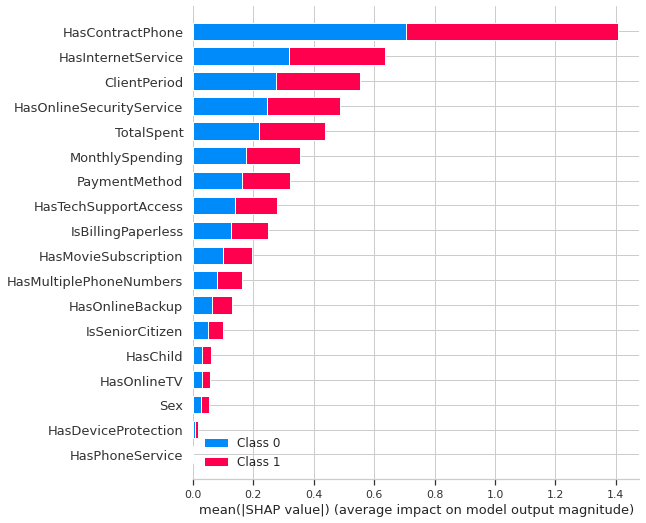

In [ ]:
feature_imp(model_lgb, X_train_lgb)

In [ ]:
y_pred_lgb = model_lgb.predict(X_test_lgb)

In [ ]:
submission('lgb_1', y_pred_lgb)

## 5.3 CatBoost

In [ ]:
from catboost import cv
from catboost import Pool, CatBoostClassifier

ModuleNotFoundError: ignored

In [ ]:
X_train_ctb = X_train_lgb
X_test_ctb = X_test_lgb
y_train_ctb = y_train_lgb
cat_features = np.arange(3,18)

In [ ]:
cv_trainset = Pool(train=X_train_ctb,
                  label=y_train_ctb,
                  cat_features=cat_features)

In [ ]:
def objective_catboost(trial):    
    
    ctb_params = {        
        'learning_rate': trial.suggest_float('learning_rate', 0.005,0.05),
        'max_depth': trial.suggest_int( 'max_depth',  1,15,1),
        'rsm': trial.suggest_float('rsm', 0.3, 1),
        'max_ctr_complexity': trial.suggest_int( 'max_ctr_complexity',  1,3,1),
        'random_state': trial.suggest_categorical('random_state',[97]),
        'loss_function': trial.suggest_categorical('loss_function',['Logloss']),
        'eval_metric': trial.suggest_categorical('eval_metric',['AUC']),
        'silent':trial.suggest_categorical('silent',[True]), 
        'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds',[50]),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights',['Balanced']),
        'boosting_type': trial.suggest_categorical('boosting_type',['Ordered'])
        }

    cv_scores = cv(params = ctb_params,
                   pool = cv_trainset,
                   fold_count=4,
                   shuffle=True,
                   stratified=True,
                   partition_random_seed=20,
                   verbose=False,
                   num_boost_round=1000
                   )
    best_value = np.max(cv_scores['test-AUC-mean'])
    return best_value

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=50)

[I 2021-10-18 17:08:46,400] A new study created in memory with name: no-name-30eb0ff8-5437-49f9-b223-17c2e19770ea
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/4]

bestTest = 0.8532290125
bestIteration = 249

Training on fold [1/4]

bestTest = 0.8515173583
bestIteration = 284

Training on fold [2/4]

bestTest = 0.8644599522
bestIteration = 244

Training on fold [3/4]


[I 2021-10-18 17:09:41,974] Trial 0 finished with value: 0.8458805459374643 and parameters: {'learning_rate': 0.04497643901255066, 'max_depth': 13, 'rsm': 0.8312360439257402, 'max_ctr_complexity': 1, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.8458805459374643.



bestTest = 0.8169977138
bestIteration = 189

Training on fold [0/4]

bestTest = 0.855222709
bestIteration = 439

Training on fold [1/4]

bestTest = 0.8474329664
bestIteration = 82

Training on fold [2/4]

bestTest = 0.8654427562
bestIteration = 472

Training on fold [3/4]


[I 2021-10-18 17:10:08,421] Trial 1 finished with value: 0.8461564244638227 and parameters: {'learning_rate': 0.02213372656541329, 'max_depth': 15, 'rsm': 0.5540992668966611, 'max_ctr_complexity': 1, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.8461564244638227.



bestTest = 0.8172224403
bestIteration = 346

Training on fold [0/4]

bestTest = 0.8539647104
bestIteration = 800

Training on fold [1/4]

bestTest = 0.8527440189
bestIteration = 862

Training on fold [2/4]

bestTest = 0.8641258588
bestIteration = 486

Training on fold [3/4]


[I 2021-10-18 17:10:25,494] Trial 2 finished with value: 0.8470735351928155 and parameters: {'learning_rate': 0.02539271992166577, 'max_depth': 1, 'rsm': 0.46430753965758786, 'max_ctr_complexity': 1, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.8470735351928155.



bestTest = 0.8179685323
bestIteration = 657

Training on fold [0/4]

bestTest = 0.8536244687
bestIteration = 296

Training on fold [1/4]

bestTest = 0.8541005086
bestIteration = 468

Training on fold [2/4]

bestTest = 0.8649528524
bestIteration = 351

Training on fold [3/4]


[I 2021-10-18 17:10:39,776] Trial 3 finished with value: 0.8470844423433096 and parameters: {'learning_rate': 0.02766649372298178, 'max_depth': 5, 'rsm': 0.7441850096275799, 'max_ctr_complexity': 1, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 3 with value: 0.8470844423433096.



bestTest = 0.8167520128
bestIteration = 170

Training on fold [0/4]

bestTest = 0.8544332888
bestIteration = 770

Training on fold [1/4]

bestTest = 0.8529708467
bestIteration = 998

Training on fold [2/4]

bestTest = 0.864966336
bestIteration = 809

Training on fold [3/4]


[I 2021-10-18 17:11:05,302] Trial 4 finished with value: 0.8475216944003477 and parameters: {'learning_rate': 0.01371723228647407, 'max_depth': 2, 'rsm': 0.6233043984779784, 'max_ctr_complexity': 3, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8180778992
bestIteration = 663

Training on fold [0/4]

bestTest = 0.8536587914
bestIteration = 177

Training on fold [1/4]

bestTest = 0.853833389
bestIteration = 258

Training on fold [2/4]

bestTest = 0.8656375191
bestIteration = 215

Training on fold [3/4]


[I 2021-10-18 17:11:47,522] Trial 5 finished with value: 0.8469709333736157 and parameters: {'learning_rate': 0.04989101088162422, 'max_depth': 10, 'rsm': 0.8897718480603656, 'max_ctr_complexity': 2, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8168973359
bestIteration = 163

Training on fold [0/4]

bestTest = 0.8534633017
bestIteration = 193

Training on fold [1/4]

bestTest = 0.8555226589
bestIteration = 280

Training on fold [2/4]

bestTest = 0.865221026
bestIteration = 233

Training on fold [3/4]


[I 2021-10-18 17:12:09,621] Trial 6 finished with value: 0.8466224332956147 and parameters: {'learning_rate': 0.04378514664118062, 'max_depth': 7, 'rsm': 0.9942158723212942, 'max_ctr_complexity': 2, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8152283671
bestIteration = 194

Training on fold [0/4]

bestTest = 0.8542870446
bestIteration = 204

Training on fold [1/4]

bestTest = 0.8528156487
bestIteration = 271

Training on fold [2/4]

bestTest = 0.8658352785
bestIteration = 228

Training on fold [3/4]


[I 2021-10-18 17:12:23,642] Trial 7 finished with value: 0.8471388554446785 and parameters: {'learning_rate': 0.04513739292241726, 'max_depth': 6, 'rsm': 0.4520647703754205, 'max_ctr_complexity': 3, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8176299444
bestIteration = 168

Training on fold [0/4]

bestTest = 0.8541542309
bestIteration = 566

Training on fold [1/4]

bestTest = 0.8531991667
bestIteration = 845

Training on fold [2/4]

bestTest = 0.8647775657
bestIteration = 634

Training on fold [3/4]


[I 2021-10-18 17:12:44,761] Trial 8 finished with value: 0.8444545962789813 and parameters: {'learning_rate': 0.015604435376140022, 'max_depth': 4, 'rsm': 0.9773061644611465, 'max_ctr_complexity': 1, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8093989615
bestIteration = 26

Training on fold [0/4]

bestTest = 0.854501934
bestIteration = 451

Training on fold [1/4]

bestTest = 0.8536946063
bestIteration = 551

Training on fold [2/4]

bestTest = 0.8657948277
bestIteration = 508

Training on fold [3/4]


[I 2021-10-18 17:13:17,340] Trial 9 finished with value: 0.8472034876330297 and parameters: {'learning_rate': 0.022735098399260356, 'max_depth': 8, 'rsm': 0.5126229323045988, 'max_ctr_complexity': 2, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8161272731
bestIteration = 379

Training on fold [0/4]

bestTest = 0.8488237787
bestIteration = 987

Training on fold [1/4]

bestTest = 0.8446886491
bestIteration = 978

Training on fold [2/4]

bestTest = 0.8472084473
bestIteration = 29

Training on fold [3/4]


[I 2021-10-18 17:13:29,622] Trial 10 finished with value: 0.8350332800258368 and parameters: {'learning_rate': 0.005450061220255261, 'max_depth': 1, 'rsm': 0.3375557175787797, 'max_ctr_complexity': 3, 'random_state': 97, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'silent': True, 'early_stopping_rounds': 50, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered'}. Best is trial 4 with value: 0.8475216944003477.



bestTest = 0.8021343026
bestIteration = 39

Training on fold [0/4]

bestTest = 0.8549152977
bestIteration = 767

Training on fold [1/4]


KeyboardInterrupt: ignored